# Coulomb Repulsion Matrices & Tanabe-Sugano Diagrams for the O group

- Parse all CG coefficients from Appendix II.
- Parse all Coulomb repulsion matrices from Appendix IV and compare against results found using qdef.

For doing this `CrystalElectronsSCoupling` and `CrystalElectronsLLCoupling` where modified so that the group now has to be provided to the instance of the class, this allows for flexibility in modifiying the group before passing it to them.

The results of these calculations were saved as a pickle whose contents are dictionaries index by number of electrons, and terms. The filename for this pickle is `./data/all_terms.pkl`. Most of the filesize in this pickle is used for storing the eigenstates, a slim version `all_terms_trimmed.pkl`, does not include them.

In addition to these symbolic results, the data necessary to compute Tanabe-Sugano diagrams was also created by varying C/B over a range of values. These data are store in the file `./data/stk_diag.h5`. These data were generated in section "Big export". An interactive viewer of this dataset was created in notebook `Tanabe Sugano Diagrams.nb`.

In here is also the development code for creating an loading split pickle files, which is useful for satisfying filesize limitation on GitHub. These two functions `split_load` and `split_dump` can now be found in the `misc.py` module.

The block of code #1645044473 generates figures for Tanabe-Sugano diagrams.

Block #1645044557 creates a LaTeX output of matrices.

In section "LS Coupling Allowed Terms" is the development code of a function which can be used to compute allowed terms in LS coupling. The function developed there, `LS_allowed_terms` was added to the `qdef.py` module. 

Some of the functionality of this notebook was sequentialized in the script `tsk_diagrams.py`.

In [14]:
%load_ext autoreload
%autoreload 2
# provide cell timings
%load_ext autotime
from qdef import *
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
import sympy as sp
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matrixgoodies import *
from uncertainties import ufloat
from misc import *
plot_style = 'default'
plt.style.use(plot_style)
import copy
from collections import Counter
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [15]:
# import h5py
# import numpy as np
# from itertools import product

# f0 = './data/tsk_hypercube.h5'
# f1 = './data/tsk_hypercube_addendum.h5'
# tot = './data/tsk_hypercube_total_float32.h5'
# num_type = np.float32
# h0 = h5py.File(f0,'r')
# keys_0 = list(h0.keys())
# h1 = h5py.File(f1,'r')
# keys_1 = list(h1.keys())
# with h5py.File(tot,'w') as h5_file:
#     for num_electrons, idx0, idx1 in product([2,3,4,5,6,7,8,9],range(111),range(111)):
#         key = '/%d/%d/%d' % (num_electrons, idx0, idx1)
#         data = np.array(h0[key]).astype(num_type)
#         h5_file.create_dataset(key, data = data)
#     for num_electrons, idx0, idx1 in product([1],range(111),range(111)):
#         key = '/%d/%d/%d' % (num_electrons, idx0, idx1)
#         data = np.array(h1[key]).astype(num_type)
#         h5_file.create_dataset(key, data = data)
#     for key in '/params/Dqs_B /params/zetas_B /params/gammas_B'.split(' '):
#         data = np.array(h1[key]).astype(num_type)
#         h5_file.create_dataset(key, data = data)
# h0.close()
# h1.close()

In [16]:
# subs = {sp.Symbol('F_{(4)}') : sp.Symbol('F^{(4)}')/441,
#         sp.Symbol('F_{(0)}'): sp.Symbol('F^{(0)}'),
#         sp.Symbol('F_{(2)}'): sp.Symbol('F^{(2)}')/49}
# A = sp.Symbol('F_{(0)}') - 49 * sp.Symbol('F_{(4)}')
# A = A.subs(subs)
# B = sp.Symbol('F_{(2)}') - 5 * sp.Symbol('F_{(4)}')
# B = B.subs(subs)
# C = 35*sp.Symbol('F_{(4)}')
# C = C.subs(subs)
# slater_to_racah = sp.solve([sp.Symbol('A') - A, 
#                         sp.Symbol('B') - B,
#                         sp.Symbol('C') - C],
#                         (sp.Symbol('F^{(0)}'), sp.Symbol('F^{(2)}'), sp.Symbol('F^{(4)}')))
# racah_to_slater = sp.solve([sp.Symbol('A') - A, 
# sp.Symbol('B') - B,
# sp.Symbol('C') - C],
# (sp.Symbol('A'), sp.Symbol('B'), sp.Symbol('C')))

## Functions

In [2]:
def as_det_ket(qet):
    '''
    Parameters
    ----------
    qet (qdef.Qet)

    Returns
    -------
    detQet : a sympy expression that presents the quantum symbols in qet
             as determinantal states
    '''
    detket = sp.S(0)
    for k,v in qet.dict.items():
        kbits = []
        if isinstance(k, tuple):
            for kpart in k:
                if isinstance(kpart, SpinOrbital):
                    korb = kpart.orbital
                    kspin = kpart.spin
                    if kspin == S_DOWN:
                        kbits.append(sp.Symbol('\\bar{%s}' % str(korb)))
                    else:
                        kbits.append(sp.Symbol('%s' % str(korb)))
        else:
            kbits = k
        kbits = tuple(kbits)
        strk = (r'|%s|' % str(kbits)).replace('(','').replace(')','').replace(',','')
        symb = sp.Symbol(strk)
        detket += symb * v
    return detket

In [3]:
def config_printer(n1, n2, print_all):
    configargs = ((sp.Symbol('E'),n1), (sp.Symbol('T_2'),n2))
    config_latex = sp.Symbol('e')**n1 * sp.Symbol('t_2')**n2
    print("Calculating wave functions...")
    if configargs in config_printer.configs:
        econfig = config_printer.configs[configargs]
    else:
        econfig = CrystalElectronsLLCoupling('O',*configargs,group)
        config_printer.configs[configargs] = econfig
    terms = {}
    collected = {}
    for k,v in econfig.equiv_waves.items():
        if k.terms[-1] not in terms:
            terms[k.terms[-1]] = 0
            collected[k.terms[-1]] = []
        terms[k.terms[-1]] += 1
        collected[k.terms[-1]].append((k,v))

    terms = OrderedDict()
    econfig_maker = lambda x,y: sp.Symbol(sp.latex(x).lower()) * sp.Symbol(sp.latex(y).lower())
    for wave_key, wave in econfig.equiv_waves.items():
        this_term = wave_key.terms[-1]
        if this_term not in terms:
            terms[this_term] = []
        terms[this_term].append((wave_key,wave))
        # display(wave.as_ket())
    sorted_terms = sorted(terms.keys(), key= lambda x: x[0])
    for term in sorted_terms:
        terms[term] = list(sorted(terms[term], key=lambda x: str(x[0].γ)))
    counter = 0
    for term in sorted_terms:
        display(HTML('<hr>'))
        term_symb = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
        display(term_symb)
        num_waves = len(terms[term])
        for wave_key, wave in terms[term]:
            e_config = sp.latex(reduce(sp.Mul,wave_key.electrons)).lower()
            multiplicity = int(wave_key.S*2+1)
            M = sp.latex(wave_key.M)
            γ = sp.latex(wave_key.γ)
            the_wave = sp.latex(as_det_ket(wave))
            wave_line = '\psi_{%d}(%s,%s,M=%s,%s) = %s' % (counter+1, e_config, term_symb, M, γ, the_wave)
            counter += 1
            display(Math(wave_line))
            if not print_all:
                if num_waves != 1:
                    plurality = 's' if (num_waves-1)>1 else ''
                    msg = '(... and %d other wave function%s ...)' % (num_waves-1, plurality)
                    display(Math('\\textrm{%s}' % msg))
                break
    else:
        display(HTML('<hr>'))
config_printer.configs = {}

In [ ]:
def make_multi_term_symbol(psi_key):
    electrons = psi_key.electrons
    if len(set(electrons)) == 1:
        multi_term = sp.Symbol(str(electrons[0]).lower())**len(electrons)
    else:
        e_term = '{}^%d%s' % (psi_key.terms[0][0]*2+1, psi_key.terms[0][1])
        t2_term = '{}^%d%s' % (psi_key.terms[1][0]*2+1, psi_key.terms[1][1])
        num_es = electrons.count(sp.Symbol('E'))
        num_ts = electrons.count(sp.Symbol('T_2'))
        if num_es == 1:
            e_term = 'e'
        else:
            e_term = 'e^%d(%s)' % (num_es, e_term)
        if num_ts == 1:
            t2_term = 't_2'
        else:
            t2_term = 't_2^%d(%s)' % (num_ts, t2_term)
        multi_term = sp.Symbol('{%s}{%s}' % (t2_term, e_term))
    return multi_term
    

In [ ]:
def LS_terms_in_crystal_terms(group_label, l, num_electrons):
    allowed_LS_terms = LS_allowed_terms(l, num_electrons)
    Ls = range(0,l*num_electrons+1)
    reduction = {}
    for L in Ls:
        the_split = l_splitter(group_label,L)
        the_big_term = l_from_num_to_lett[L].upper()
        for split_irrep, count in the_split.dict.items():
            if split_irrep not in reduction:
                reduction[split_irrep] = []
            reduction[split_irrep].append(the_big_term)
    spin_reduction = {}
    for mult, Ls in allowed_LS_terms.items():
        for irrep, cterms in reduction.items():
            inters = [c for c in Ls if c in cterms]
            if len(inters) > 0:
                spin_reduction[(mult,irrep)] = Counter(inters)
    return spin_reduction


##  Parsing coupling coefficients from Appendix II

### Parsing

In [4]:
group_label = 'O'
group = CPGs.get_group_by_label(group_label)
original_component_labels = copy.deepcopy(group.component_labels)
original_CG_coefficients = copy.deepcopy(group.CG_coefficients)
original_CG_coefficients_partitioned = copy.deepcopy(group.CG_coefficients_partitioned)

In [5]:
Γ1, Γ2 = sp.Symbol('E'), sp.Symbol('E')
cgs = group.CG_coefficients
Γ12s = group.product_table.odict[(Γ1, Γ2)]
comps_12 = sum([group.component_labels[key] for key in Γ12s],[])
CG_matrix = []
firstcol = []
for idx1, c1 in enumerate(group.component_labels[Γ1]):
    for idx2, c2 in enumerate(group.component_labels[Γ2]):
        row = [cgs[(c1,c2,c3)] for c3 in comps_12]
        firstcol.append([c1,c2])
        CG_matrix.append(row)
CG_matrix = sp.Matrix(CG_matrix)
CG_matrix = sp.Matrix(
sp.BlockMatrix([
    [sp.Matrix([[Γ1, Γ2]]), sp.Matrix([comps_12])],
    [sp.Matrix(firstcol), CG_matrix]
    ]
))
display(CG_matrix)

Matrix([
[    E,     E,   a_{A_1},    a_{A_2},      u_{E},     v_{E}],
[u_{E}, u_{E}, sqrt(2)/2,          0, -sqrt(2)/2,         0],
[u_{E}, v_{E},         0, -sqrt(2)/2,          0, sqrt(2)/2],
[v_{E}, u_{E},         0,  sqrt(2)/2,          0, sqrt(2)/2],
[v_{E}, v_{E}, sqrt(2)/2,          0,  sqrt(2)/2,         0]])

In [6]:
# group.component_labels = copy.copy(original_component_labels)
# group.CG_coefficients = copy.copy(original_CG_coefficients)
# waves = CrystalElectronsSCoupling('O',(sp.Symbol('E'),sp.Symbol('E')), group)

# for wavekey, wave in waves.inequiv_waves.items():
#     if wavekey.γ == sp.Symbol('u_{E}') and wavekey.M == 1:
#         print(wavekey)
#         print(wave)

# for k, v in group.CG_coefficients_partitioned[(sp.Symbol('E'),sp.Symbol('E'))].items():
#     if k[:2] == (sp.Symbol('v_{E}'), sp.Symbol('v_{E}')):
#         print(k,v)

In [ ]:
group.component_labels[sp.Symbol('A_1')] = 'e_1'
group.component_labels[sp.Symbol('A_2')] = 'e_2'
group.component_labels[sp.Symbol('E')] = 'u v'
group.component_labels[sp.Symbol('T_1')] = '\\alpha \\beta \\gamma'
group.component_labels[sp.Symbol('T_2')] = '\\xi \\eta \\zeta'
for k in group.component_labels:
    group.component_labels[k] = list(map(sp.Symbol,group.component_labels[k].split(' ')))

rawcgs = '''
A1xA1xA1
1

A1xA2xA2
1

A1xExE
1 0
0 1

A1xT1xT1
1 0 0
0 1 0
0 0 1

A1xT2xT2
1 0 0
0 1 0
0 0 1

A2xA2xA1
-1

A2xExE
0 -1
1 0

A2xT1xT2
1 0 0
0 1 0
0 0 1

A2xT2xT1
-1 0 0
0 -1 0
0 0 -1

ExExA1xA2xE
1/2 0 -1/2 0
0 1/2 0 1/2
0 -1/2 0 1/2
1/2 0 1/2 0

ExT1xT1xT2
-1/4 0 0 3/4 0 0
0 -1/4 0 0 -3/4 0
0 0 1 0 0 0
3/4 0 0 1/4 0 0
0 -3/4 0 0 1/4 0
0 0 0 0 0 -1

ExT2xT1xT2
-3/4 0 0 -1/4 0 0
0 3/4 0 0 -1/4 0
0 0 0 0 0 1
-1/4 0 0 3/4 0 0
0 -1/4 0 0 -3/4 0
0 0 1 0 0 0

T1xT1xA1xExT1xT2
-1/3 1/6 -1/2 0 0 0 0 0 0
0 0 0 0 0 -1/2 0 0 -1/2
0 0 0 0 1/2 0 0 -1/2 0
0 0 0 0 0 1/2 0 0 -1/2
-1/3 1/6 1/2 0 0 0 0 0 0
0 0 0 -1/2 0 0 -1/2 0 0
0 0 0 0 -1/2 0 0 -1/2 0
0 0 0 1/2 0 0 -1/2 0 0
-1/3 -4/6 0 0 0 0 0 0 0

T1xT2xA2xExT1xT2
-1/3 -1/2 -1/6 0 0 0 0 0 0
0 0 0 0 0 1/2 0 0 -1/2
0 0 0 0 1/2 0 0 1/2 0
0 0 0 0 0 1/2 0 0 1/2
-1/3 1/2 -1/6 0 0 0 0 0 0
0 0 0 1/2 0 0 -1/2 0 0
0 0 0 0 1/2 0 0 -1/2 0
0 0 0 1/2 0 0 1/2 0 0
-1/3 0 4/6 0 0 0 0 0 0

T2xT2xA1xExT1xT2
1/3 -1/6 1/2 0 0 0 0 0 0
0 0 0 0 0 1/2 0 0 1/2
0 0 0 0 -1/2 0 0 1/2 0
0 0 0 0 0 -1/2 0 0 1/2
1/3 -1/6 -1/2 0 0 0 0 0 0
0 0 0 1/2 0 0 1/2 0 0
0 0 0 0 1/2 0 0 1/2 0
0 0 0 -1/2 0 0 1/2 0 0
1/3 4/6 0 0 0 0 0 0 0
'''
cgs = {}
reductions = {}
for line in rawcgs.split('\n'):
    if line == '':
        continue
    if "x" in line:
        line = line.replace('1','_1').replace('2','_2')
        irrep0, irrep1, reducedto = line.split('x')[0], line.split('x')[1], line.split('x')[2:]
        reducedto = list(map(sp.Symbol, reducedto))
        key = (sp.Symbol(irrep0), sp.Symbol(irrep1))
        reductions[key] = reducedto
        cgs[key] = []
    else:
        nums = list(map(sp.S, line.split(' ')))
        nums = [sp.sign(num) * sp.sqrt(sp.sign(num)*num) for num in nums]
        cgs[key].append(nums)
for ir0ir1key in cgs:
    cgs[ir0ir1key] = sp.Matrix(cgs[ir0ir1key])
    print(ir0ir1key)
    display(cgs[ir0ir1key])

clebsch_gees = {}
clebsch_gees_partitioned = {}
for ir0ir1key in cgs:
    clebsch_gees_partitioned[ir0ir1key] = {}
    Γ0, Γ1 = ir0ir1key
    clebsch_gees_partitioned[(ir0ir1key[1], ir0ir1key[0])] = {}
    comps_0 = group.component_labels[Γ0]
    comps_1 = group.component_labels[Γ1]
    comps_2 = sum([group.component_labels[key] for key in reductions[ir0ir1key]],[])
    row = 0
    for idx0, c0 in enumerate(comps_0):
        for idx1, c1 in enumerate(comps_1):
            # row = idx0 * len(comps_0) + idx1
            # if ir0ir1key == (sp.Symbol('E'), sp.Symbol('T_2')):
            #     print(row)
            matrix_row = cgs[ir0ir1key][row,:]
            matrix_vals = {(c0, c1, c2):val for (c2, val) in zip(comps_2, matrix_row)}
            # if (Γ0, Γ1) == (sp.Symbol('E'), sp.Symbol('E')):
            #     print(matrix_vals)
            clebsch_gees.update(matrix_vals)
            clebsch_gees_partitioned[ir0ir1key].update(matrix_vals)
            row += 1
            if Γ0 != Γ1:
                matrix_vals = {(c1, c0, c2):val for  (c2, val) in zip(comps_2, matrix_row)}
                clebsch_gees.update(matrix_vals)
                if (Γ1, Γ0) not in clebsch_gees_partitioned:
                    clebsch_gees_partitioned[(Γ1, Γ0)] = {}
                clebsch_gees_partitioned[(Γ1, Γ0)].update(matrix_vals)
group.CG_coefficients = clebsch_gees
group.CG_coefficients_partitioned = clebsch_gees_partitioned

sym_bases = {}
sym_bases[sp.Symbol('E')] = [
    [Qet({(2, 0) : 1}), # u
     Qet({(2, 2) : 1/sp.sqrt(2),
          (2,-2) : 1/sp.sqrt(2)})] # v
        ]

sym_bases[sp.Symbol('T_2')] = [
            [sp.I/sp.sqrt(2) * Qet({(2,1):1, (2,-1):1}), # xi
            -1/sp.sqrt(2) * Qet({(2,1):1, (2,-1):-1}), # eta
            -sp.I/sp.sqrt(2) * Qet({(2,2):1, (2,-2):-1}) # zeta
            ]
        ]

basis_change = {}
for irrep, qets in sym_bases.items():
    components = group.component_labels[irrep]
    if isinstance(qets, list):
        qets = qets[0]
    for component, qet in zip(components, qets):
        basis_change[component] = qet

orbital_basis_change = {}
for k in basis_change:
    for spin in [S_DOWN, S_UP]:
        new_k = SpinOrbital(k,spin)
        orbital_basis_change[new_k] = Qet({k+(spin,):v for k,v in basis_change[k].dict.items()})

### Displaying (this is non-essential for the following sections)

In [343]:
Γ1, Γ2 = sp.Symbol('E'), sp.Symbol('T_2')
cgs = group.CG_coefficients
Γ12s = group.product_table.odict[(Γ1, Γ2)]
comps_12 = sum([group.component_labels[key] for key in Γ12s],[])
CG_matrix = []
firstcol = []
for idx1, c1 in enumerate(group.component_labels[Γ1]):
    for idx2, c2 in enumerate(group.component_labels[Γ2]):
        row = [cgs[(c1,c2,c3)] for c3 in comps_12]
        firstcol.append([c1,c2])
        CG_matrix.append(row)
CG_matrix = sp.Matrix(CG_matrix)
CG_matrix = sp.Matrix(
sp.BlockMatrix([
    [sp.Matrix([[Γ1, Γ2]]), sp.Matrix([comps_12])],
    [sp.Matrix(firstcol), CG_matrix]
    ]
))
display(CG_matrix)

Matrix([
[E,   T_2,     \alpha,     \beta, \gamma,       \xi,       \eta, \zeta],
[u,   \xi, -sqrt(3)/2,         0,      0,      -1/2,          0,     0],
[u,  \eta,          0, sqrt(3)/2,      0,         0,       -1/2,     0],
[u, \zeta,          0,         0,      0,         0,          0,     1],
[v,   \xi,       -1/2,         0,      0, sqrt(3)/2,          0,     0],
[v,  \eta,          0,      -1/2,      0,         0, -sqrt(3)/2,     0],
[v, \zeta,          0,         0,      1,         0,          0,     0]])

In [344]:
for Γ1, Γ2 in product(group.irrep_labels, group.irrep_labels):
    cgs = group.CG_coefficients
    Γ12s = group.product_table.odict[(Γ1, Γ2)]
    comps_12 = sum([group.component_labels[key] for key in Γ12s],[])
    CG_matrix = []
    firstcol = []
    for idx1, c1 in enumerate(group.component_labels[Γ1]):
        for idx2, c2 in enumerate(group.component_labels[Γ2]):
            row = [cgs.setdefault((c1,c2,c3),0) for c3 in comps_12]
            firstcol.append([c1,c2])
            CG_matrix.append(row)
    CG_matrix = sp.Matrix(CG_matrix)
    CG_matrix = sp.Matrix(
    sp.BlockMatrix([
        [sp.Matrix([[Γ1, Γ2]]), sp.Matrix([comps_12])],
        [sp.Matrix(firstcol), CG_matrix]
        ]
    ))
    display(CG_matrix)

Matrix([
[A_1, A_1, e_1],
[e_1, e_1,   1]])

Matrix([
[A_1, A_2, e_2],
[e_1, e_2,   1]])

Matrix([
[A_1, E, u, v],
[e_1, u, 1, 0],
[e_1, v, 0, 1]])

Matrix([
[A_1,    T_1, \alpha, \beta, \gamma],
[e_1, \alpha,      1,     0,      0],
[e_1,  \beta,      0,     1,      0],
[e_1, \gamma,      0,     0,      1]])

Matrix([
[A_1,   T_2, \xi, \eta, \zeta],
[e_1,   \xi,   1,    0,     0],
[e_1,  \eta,   0,    1,     0],
[e_1, \zeta,   0,    0,     1]])

Matrix([
[A_2, A_1, e_2],
[e_2, e_1,   1]])

Matrix([
[A_2, A_2, e_1],
[e_2, e_2,  -1]])

Matrix([
[A_2, E, u,  v],
[e_2, u, 0, -1],
[e_2, v, 1,  0]])

Matrix([
[A_2,    T_1, \xi, \eta, \zeta],
[e_2, \alpha,   1,    0,     0],
[e_2,  \beta,   0,    1,     0],
[e_2, \gamma,   0,    0,     1]])

Matrix([
[A_2,   T_2, \alpha, \beta, \gamma],
[e_2,   \xi,     -1,     0,      0],
[e_2,  \eta,      0,    -1,      0],
[e_2, \zeta,      0,     0,     -1]])

Matrix([
[E, A_1, u, v],
[u, e_1, 1, 0],
[v, e_1, 0, 1]])

Matrix([
[E, A_2, u,  v],
[u, e_2, 0, -1],
[v, e_2, 1,  0]])

Matrix([
[E, E,       e_1,        e_2,          u,         v],
[u, u, sqrt(2)/2,          0, -sqrt(2)/2,         0],
[u, v,         0,  sqrt(2)/2,          0, sqrt(2)/2],
[v, u,         0, -sqrt(2)/2,          0, sqrt(2)/2],
[v, v, sqrt(2)/2,          0,  sqrt(2)/2,         0]])

Matrix([
[E,    T_1,    \alpha,      \beta, \gamma,       \xi,       \eta, \zeta],
[u, \alpha,      -1/2,          0,      0, sqrt(3)/2,          0,     0],
[u,  \beta,         0,       -1/2,      0,         0, -sqrt(3)/2,     0],
[u, \gamma,         0,          0,      1,         0,          0,     0],
[v, \alpha, sqrt(3)/2,          0,      0,       1/2,          0,     0],
[v,  \beta,         0, -sqrt(3)/2,      0,         0,        1/2,     0],
[v, \gamma,         0,          0,      0,         0,          0,    -1]])

Matrix([
[E,   T_2,     \alpha,     \beta, \gamma,       \xi,       \eta, \zeta],
[u,   \xi, -sqrt(3)/2,         0,      0,      -1/2,          0,     0],
[u,  \eta,          0, sqrt(3)/2,      0,         0,       -1/2,     0],
[u, \zeta,          0,         0,      0,         0,          0,     1],
[v,   \xi,       -1/2,         0,      0, sqrt(3)/2,          0,     0],
[v,  \eta,          0,      -1/2,      0,         0, -sqrt(3)/2,     0],
[v, \zeta,          0,         0,      1,         0,          0,     0]])

Matrix([
[   T_1, A_1, \alpha, \beta, \gamma],
[\alpha, e_1,      1,     0,      0],
[ \beta, e_1,      0,     1,      0],
[\gamma, e_1,      0,     0,      1]])

Matrix([
[   T_1, A_2, \xi, \eta, \zeta],
[\alpha, e_2,   1,    0,     0],
[ \beta, e_2,   0,    1,     0],
[\gamma, e_2,   0,    0,     1]])

Matrix([
[   T_1, E,    \alpha,      \beta, \gamma,       \xi,       \eta, \zeta],
[\alpha, u,      -1/2,          0,      0, sqrt(3)/2,          0,     0],
[\alpha, v, sqrt(3)/2,          0,      0,       1/2,          0,     0],
[ \beta, u,         0,       -1/2,      0,         0, -sqrt(3)/2,     0],
[ \beta, v,         0, -sqrt(3)/2,      0,         0,        1/2,     0],
[\gamma, u,         0,          0,      1,         0,          0,     0],
[\gamma, v,         0,          0,      0,         0,          0,    -1]])

Matrix([
[   T_1,    T_1,        e_1,          u,          v,     \alpha,      \beta,     \gamma,        \xi,       \eta,      \zeta],
[\alpha, \alpha, -sqrt(3)/3,  sqrt(6)/6, -sqrt(2)/2,          0,          0,          0,          0,          0,          0],
[\alpha,  \beta,          0,          0,          0,          0,          0, -sqrt(2)/2,          0,          0, -sqrt(2)/2],
[\alpha, \gamma,          0,          0,          0,          0,  sqrt(2)/2,          0,          0, -sqrt(2)/2,          0],
[ \beta, \alpha,          0,          0,          0,          0,          0,  sqrt(2)/2,          0,          0, -sqrt(2)/2],
[ \beta,  \beta, -sqrt(3)/3,  sqrt(6)/6,  sqrt(2)/2,          0,          0,          0,          0,          0,          0],
[ \beta, \gamma,          0,          0,          0, -sqrt(2)/2,          0,          0, -sqrt(2)/2,          0,          0],
[\gamma, \alpha,          0,          0,          0,          0, -sqrt(2)/2,          0,          0, -sqrt(2)

Matrix([
[   T_1,   T_2,        e_2,          u,          v,    \alpha,     \beta,    \gamma,        \xi,       \eta,      \zeta],
[\alpha,   \xi, -sqrt(3)/3, -sqrt(2)/2, -sqrt(6)/6,         0,         0,         0,          0,          0,          0],
[\alpha,  \eta,          0,          0,          0,         0,         0, sqrt(2)/2,          0,          0, -sqrt(2)/2],
[\alpha, \zeta,          0,          0,          0,         0, sqrt(2)/2,         0,          0,  sqrt(2)/2,          0],
[ \beta,   \xi,          0,          0,          0,         0,         0, sqrt(2)/2,          0,          0,  sqrt(2)/2],
[ \beta,  \eta, -sqrt(3)/3,  sqrt(2)/2, -sqrt(6)/6,         0,         0,         0,          0,          0,          0],
[ \beta, \zeta,          0,          0,          0, sqrt(2)/2,         0,         0, -sqrt(2)/2,          0,          0],
[\gamma,   \xi,          0,          0,          0,         0, sqrt(2)/2,         0,          0, -sqrt(2)/2,          0],
[\gamma,  \eta,

Matrix([
[  T_2, A_1, \xi, \eta, \zeta],
[  \xi, e_1,   1,    0,     0],
[ \eta, e_1,   0,    1,     0],
[\zeta, e_1,   0,    0,     1]])

Matrix([
[  T_2, A_2, \alpha, \beta, \gamma],
[  \xi, e_2,     -1,     0,      0],
[ \eta, e_2,      0,    -1,      0],
[\zeta, e_2,      0,     0,     -1]])

Matrix([
[  T_2, E,     \alpha,     \beta, \gamma,       \xi,       \eta, \zeta],
[  \xi, u, -sqrt(3)/2,         0,      0,      -1/2,          0,     0],
[  \xi, v,       -1/2,         0,      0, sqrt(3)/2,          0,     0],
[ \eta, u,          0, sqrt(3)/2,      0,         0,       -1/2,     0],
[ \eta, v,          0,      -1/2,      0,         0, -sqrt(3)/2,     0],
[\zeta, u,          0,         0,      0,         0,          0,     1],
[\zeta, v,          0,         0,      1,         0,          0,     0]])

Matrix([
[  T_2,    T_1,        e_2,          u,          v,    \alpha,     \beta,    \gamma,        \xi,       \eta,      \zeta],
[  \xi, \alpha, -sqrt(3)/3, -sqrt(2)/2, -sqrt(6)/6,         0,         0,         0,          0,          0,          0],
[  \xi,  \beta,          0,          0,          0,         0,         0, sqrt(2)/2,          0,          0,  sqrt(2)/2],
[  \xi, \gamma,          0,          0,          0,         0, sqrt(2)/2,         0,          0, -sqrt(2)/2,          0],
[ \eta, \alpha,          0,          0,          0,         0,         0, sqrt(2)/2,          0,          0, -sqrt(2)/2],
[ \eta,  \beta, -sqrt(3)/3,  sqrt(2)/2, -sqrt(6)/6,         0,         0,         0,          0,          0,          0],
[ \eta, \gamma,          0,          0,          0, sqrt(2)/2,         0,         0,  sqrt(2)/2,          0,          0],
[\zeta, \alpha,          0,          0,          0,         0, sqrt(2)/2,         0,          0,  sqrt(2)/2,          0],
[\zeta,  \beta,

Matrix([
[  T_2,   T_2,       e_1,          u,          v,     \alpha,      \beta,     \gamma,       \xi,      \eta,     \zeta],
[  \xi,   \xi, sqrt(3)/3, -sqrt(6)/6,  sqrt(2)/2,          0,          0,          0,         0,         0,         0],
[  \xi,  \eta,         0,          0,          0,          0,          0,  sqrt(2)/2,         0,         0, sqrt(2)/2],
[  \xi, \zeta,         0,          0,          0,          0, -sqrt(2)/2,          0,         0, sqrt(2)/2,         0],
[ \eta,   \xi,         0,          0,          0,          0,          0, -sqrt(2)/2,         0,         0, sqrt(2)/2],
[ \eta,  \eta, sqrt(3)/3, -sqrt(6)/6, -sqrt(2)/2,          0,          0,          0,         0,         0,         0],
[ \eta, \zeta,         0,          0,          0,  sqrt(2)/2,          0,          0, sqrt(2)/2,         0,         0],
[\zeta,   \xi,         0,          0,          0,          0,  sqrt(2)/2,          0,         0, sqrt(2)/2,         0],
[\zeta,  \eta,         0,      

## 2 electrons

In [328]:
basis_change = {}
for irrep, qets in sym_bases.items():
    components = group.component_labels[irrep]
    if isinstance(qets, list):
        qets = qets[0]
    for component, qet in zip(components, qets):
        basis_change[component] = qet

orbital_basis_change = {}
for k in basis_change:
    for spin in [S_DOWN, S_UP]:
        new_k = SpinOrbital(k,spin)
        orbital_basis_change[new_k] = Qet({k+(spin,):v for k,v in basis_change[k].dict.items()})

In [329]:
# generate all the two - electron wavefunctions 
# that correspond to two electrons
two_electrons = []
num_electrons = 2
for config in config_layout('O', 2, num_electrons):
    Γ1s = config[0]
    if len(config) == 1:
        Γ2s = []
    else:
        Γ2s = config[1]
    two_electrons.append((config,CrystalElectronsLLCoupling('O', Γ1s, Γ2s, group)))

# group them in terms
all_terms = OrderedDict()
all_qets = {}
Λ = namedtuple('Λ',['electrons','term','γ']) 
component_labels = group.component_labels
for two_e_config in two_electrons:
    for wave_key, wave_qet in two_e_config[1].equiv_waves.items():
        term_sector = wave_key.terms[-1]
        term_pivot = component_labels[term_sector[1]][0]
        all_qets[wave_key] = wave_qet
        if term_sector not in all_terms:
            all_terms[term_sector] = OrderedDict()
        if wave_key.γ == term_pivot:
            all_terms[term_sector][wave_key] = (wave_qet)

In [330]:
# counter = 1
# for term_key, waves in all_terms.items():
#     term_symbol = sp.Symbol('{}^%d%s' % (term_key[0]*2+1, term_key[1]))
#     display(term_symbol)
#     for wave_key, wave in waves.items():
#         print(wave_key)
#         print(counter)
#         counter += 1
#         display(as_det_ket(wave))

In [331]:
solution = {'matrices': {},
            'sympy expressions': {},
            'numpy functions': {}}
gamma_ratio = {sp.Symbol('C'): sp.Symbol('\\gamma_{CB}') * sp.Symbol('B')}
for term, term_waves in all_terms.items():
    # if term != (0, sp.Symbol('A_1')):
    #     continue
    this_waves = term_waves
    energy_matrix = []
    for idx0, qet0 in enumerate(term_waves.values()):
        row = []
        # print('q0',idx0,qet0.norm())
        for idx1, qet1 in enumerate(term_waves.values()):
            # print('q1',idx1,qet1.norm())
            two_braket = double_electron_braket(qet0, qet1)
            matrix_element = double_braket_basis_change(two_braket, orbital_basis_change)
            matrix_element_as_slater = matrix_element.apply(to_slater_params)
            mat_element = sp.expand(matrix_element_as_slater.as_symbol_sum()).subs(SLATER_TO_RACAH)
            # mat_element = mat_element.subs(gamma_ratio)
            # single_elec_element = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
            row.append(mat_element)
            # break
        energy_matrix.append(row)
        # break
    energy_matrix = sp.Matrix(energy_matrix)
    energy_matrix = sp.expand(energy_matrix).subs({sp.Symbol('A'):0})
    the_block = block_form(energy_matrix)[1][0]
    # the_block = energy_matrix
    solution['matrices'][term] = the_block
    try:
        eigenfuns = list(the_block.eigenvals().keys())
        solution['sympy expressions'][term] = eigenfuns
        solution['numpy functions'][term] = [sp.lambdify((sp.Symbol('Dq'),sp.Symbol('\\gamma_{CB}')), eigenfun) for eigenfun in eigenfuns]
    except:
        solution['sympy expressions'][term] = None
        solution['numpy functions'][term] = None
    # break

In [332]:
for k, v in solution['matrices'].items():
    term_symb = sp.Symbol('{}^{%d}{%s}' % (k[0]*2+1, k[1]))
    display(term_symb)
    display(v)

{}^{1}{A_1}

Matrix([
[             10*B + 5*C, 2*sqrt(6)*B + sqrt(6)*C],
[2*sqrt(6)*B + sqrt(6)*C,               8*B + 4*C]])

{}^{1}{E}

Matrix([
[     B + 2*C, -2*sqrt(3)*B],
[-2*sqrt(3)*B,          2*C]])

{}^{3}{T_1}

Matrix([
[-5*B, -6*B],
[-6*B,  4*B]])

{}^{1}{T_2}

Matrix([
[    B + 2*C, 2*sqrt(3)*B],
[2*sqrt(3)*B,         2*C]])

{}^{3}{T_2}

Matrix([[-8*B]])

{}^{1}{T_1}

Matrix([[4*B + 2*C]])

{}^{3}{A_2}

Matrix([[-8*B]])

In [ ]:
config_printer.configs = {}
config_printer(1,1,True)

## 3-electrons

In [345]:
from collections import Counter

In [386]:
# generate all the two - electron wavefunctions 
# that correspond to two electrons
n_electrons = []
num_electrons = 3
for config in config_layout('O', 2, num_electrons):
    Γ1s = config[0]
    if len(config) == 1:
        Γ2s = []
    else:
        Γ2s = config[1]
    n_electrons.append((config,CrystalElectronsLLCoupling('O', Γ1s, Γ2s, group)))

# group them in terms
all_terms = OrderedDict()
all_qets = {}
Λ = namedtuple('Λ',['electrons','term','γ']) 
component_labels = group.component_labels
wave_keys = []
for a_config in n_electrons:
    for wave_key, wave_qet in a_config[1].equiv_waves.items():
        term_sector = wave_key.terms[-1]
        if Counter(wave_key.electrons) == Counter([sp.Symbol('E'),sp.Symbol('E'),sp.Symbol('T_2')]):
            wave_keys.append(wave_key)
        term_pivot = component_labels[term_sector[1]][0]
        all_qets[wave_key] = wave_qet
        if term_sector not in all_terms:
            all_terms[term_sector] = OrderedDict()
        if wave_key.γ == term_pivot:
            if int(wave_key.S) == wave_key.S:
                if wave_key.M == 0:
                    all_terms[term_sector][wave_key] = (wave_qet)
            else:
                if wave_key.M == S_HALF:
                    all_terms[term_sector][wave_key] = (wave_qet)
len(all_terms[(sp.S(1)/2, sp.Symbol('T_2'))])

5

In [387]:
# chunks = sp.binomial(6,3), sp.binomial(6,2)*4, sp.binomial(4,2)*6, sp.binomial(4,3)
# chunks, sum(chunks), sp.binomial(10,3)

In [388]:
solution = {'matrices': {},
            'sympy expressions': {},
            'numpy functions': {}}
gamma_ratio = {sp.Symbol('C'): sp.Symbol('\\gamma_{CB}') * sp.Symbol('B')}
for term, term_waves in all_terms.items():
    print(term,len(term_waves))
    this_waves = term_waves
    energy_matrix = []
    for idx0, qet0 in enumerate(term_waves.values()):
        row = []
        # print('q0',idx0,qet0.norm())
        for idx1, qet1 in enumerate(term_waves.values()):
            # print('q1',idx1,qet1.norm())
            two_braket = double_electron_braket(qet0, qet1)
            matrix_element = double_braket_basis_change(two_braket, orbital_basis_change)
            matrix_element_as_slater = matrix_element.apply(to_slater_params)
            mat_element = sp.expand(matrix_element_as_slater.as_symbol_sum()).subs(SLATER_TO_RACAH)
            # mat_element = mat_element.subs(gamma_ratio)
            # single_elec_element = single_electron_braket(qet0, qet1).apply(simple_energy).as_symbol_sum()
            row.append(mat_element)
            # break
        energy_matrix.append(row)
        # break
    energy_matrix = sp.Matrix(energy_matrix)
    energy_matrix = sp.expand(energy_matrix).subs({sp.Symbol('A'):0})
    # energy_matrix = block_form(energy_matrix)[0]
    solution['matrices'][term] = energy_matrix
    try:
        eigenfuns = list(the_block.eigenvals().keys())
        solution['sympy expressions'][term] = eigenfuns
        solution['numpy functions'][term] = [sp.lambdify((sp.Symbol('Dq'),sp.Symbol('\\gamma_{CB}')), eigenfun) for eigenfun in eigenfuns]
    except:
        solution['sympy expressions'][term] = None
        solution['numpy functions'][term] = None
    # break

(1/2, T_2) 5
(1/2, T_1) 5
(3/2, A_2) 1
(1/2, E) 4
(1/2, A_1) 1
(1/2, A_2) 1
(3/2, T_1) 2
(3/2, T_2) 1


In [389]:
A, B, C, Dq, gamma = [sp.Symbol(x) for x in ['A','B','C','Dq', '\\gamma']]
three_comparison = OrderedDict([
((sp.S(1)/2, sp.Symbol('T_2')) , [
    [(5*C)/sp.S(2), -3*sp.sqrt(3)*B, -5*sp.sqrt(3)*B, 4*B + 2*C, 2*B],
    [0, (-6*B+3*C)/sp.S(2), 3*B, -3*sp.sqrt(3)*B, -3*sp.sqrt(3)*B],
    [0,0, (4*B +3*C)/sp.S(2), -sp.sqrt(3)*B, sp.sqrt(3)*B],
    [0,0,0, (6*B+5*C)/sp.S(2), 10*B],
    [0,0,0,0,(-2*B+3*C)/sp.S(2)]
    ]),
 ((sp.S(1)/2,sp.Symbol('T_1')), [
    [(-6*B+3*C)/sp.S(2), -3*B, 3*B, 0, -2*sp.sqrt(3)*B],
    [0, 3*C/sp.S(2), -3*B, 3*B, 3*sp.sqrt(3)*B],
    [0, 0, (-6*B+3*C)/sp.S(2), -3*B, -sp.sqrt(3)*B],
    [0,0,0, (-6*B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,0, (-2*B + 3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('E')), [
    [(-6*B+3*C)/sp.S(2), -6*sp.sqrt(2)*B, -3*sp.sqrt(2)*B,0],
    [0,(8*B+6*C)/sp.S(2),10*B, sp.sqrt(3)*(2*B+C)],
    [0,0,(-B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,(-8*B+4*C)/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_1')), [[-3*B/sp.S(2),6*B],
                                [0,-6*B]]),
 ((sp.S(3)/2,sp.Symbol('A_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_1')), [[(-11*B+3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_2')), [[(9*B + 3*C)/sp.S(2)]]),
])
three_comparison = OrderedDict([(k,(sp.Matrix(v)+sp.Matrix(v).T)) for k,v in three_comparison.items()])

In [390]:
for k, v in solution['matrices'].items():
    print('='*30)
    term_symb = sp.Symbol('{}^{%d}{%s}' % (k[0]*2+1, k[1]))
    # from_tsk = three_comparison[k]
    display(term_symb)
    # display(v)
    # display(v.trace())
    # display(from_tsk.trace())
    # display(sp.Matrix(list(set(v.diagonal()))).T)
    # display(sp.Matrix(list(set(from_tsk.diagonal()))).T)
    display(v)
    continue
    # display(from_tsk)
    random_subs = {sp.Symbol('B'): np.random.random(), sp.Symbol('C'): np.random.random()}
    v = v.subs(random_subs)
    from_tsk = from_tsk.subs(random_subs)
    v_spectrum = np.sort(np.linalg.eigvalsh(np.array(v,dtype=np.float64)))
    from_tsk_spectrum = np.sort(np.linalg.eigvalsh(np.array(from_tsk,dtype=np.float64)))
    spectrum_diff = np.sqrt(np.sum((v_spectrum - from_tsk_spectrum)**2))
    print("Checking spectrum equality...")
    if (spectrum_diff < 1e-6):
        print(">>> Check passed.", "Δ=", spectrum_diff)
    else:
        print(">>> Check failed.")
        print(v_spectrum, from_tsk_spectrum)

{}^{2}{T_2}

Matrix([
[         5*C, 3*sqrt(3)*B, -5*sqrt(3)*B,   4*B + 2*C,         2*B],
[ 3*sqrt(3)*B,  -6*B + 3*C,         -3*B, 3*sqrt(3)*B, 3*sqrt(3)*B],
[-5*sqrt(3)*B,        -3*B,    4*B + 3*C,  -sqrt(3)*B,   sqrt(3)*B],
[   4*B + 2*C, 3*sqrt(3)*B,   -sqrt(3)*B,   6*B + 5*C,        10*B],
[         2*B, 3*sqrt(3)*B,    sqrt(3)*B,        10*B,  -2*B + 3*C]])

{}^{2}{T_1}

Matrix([
[  -6*B + 3*C,          3*B,        3*B, -2*sqrt(3)*B,            0],
[         3*B,          3*C,        3*B, -3*sqrt(3)*B,          3*B],
[         3*B,          3*B, -6*B + 3*C,   -sqrt(3)*B,          3*B],
[-2*sqrt(3)*B, -3*sqrt(3)*B, -sqrt(3)*B,   -2*B + 3*C, -2*sqrt(3)*B],
[           0,          3*B,        3*B, -2*sqrt(3)*B,   -6*B + 3*C]])

{}^{4}{A_2}

Matrix([[-15*B]])

{}^{2}{E}

Matrix([
[  -6*B + 3*C,            -6*sqrt(2)*B, -3*sqrt(2)*B,                       0],
[-6*sqrt(2)*B,               8*B + 6*C,         10*B, 2*sqrt(3)*B + sqrt(3)*C],
[-3*sqrt(2)*B,                    10*B,     -B + 3*C,             2*sqrt(3)*B],
[           0, 2*sqrt(3)*B + sqrt(3)*C,  2*sqrt(3)*B,              -8*B + 4*C]])

{}^{2}{A_1}

Matrix([[-11*B + 3*C]])

{}^{2}{A_2}

Matrix([[9*B + 3*C]])

{}^{4}{T_1}

Matrix([
[-3*B,   6*B],
[ 6*B, -12*B]])

{}^{4}{T_2}

Matrix([[-15*B]])

## Parsing all Coulomb Interaction Matrices from TSK

In [707]:
def parse_headers(headers_string):
   headers_string = headers_string.replace('sup','{}^').replace(' ','')
   return tuple(list(map(sp.Symbol, headers_string.split(','))))
chunk = {n:{} for n in range(2,6)}
chunk[2] = OrderedDict({((0, sp.Symbol('A_1')), parse_headers('t_2^2,e^2')) : [[10*B + 5*C, sp.sqrt(6)*(2*B+C)],
                           [sp.sqrt(6)*(2*B + C), 8*B + 4*C]],
 ((0,sp.Symbol('E')), parse_headers('t_2^2,e^2') ): [[B + 2*C, -2*sp.sqrt(3)*B],
                     [-2*sp.sqrt(3)*B, 2*C]],
 ((0,sp.Symbol('T_2')), parse_headers('t_2^2,t_2{e}')): [[B + 2*C, 2*sp.sqrt(3)*B],
                     [2*sp.sqrt(3)*B, 2*C]],
 ((1, sp.Symbol('T_1')), parse_headers('t_2^2,t_2{e}') ): [[-5*B, 6*B],
                        [6*B, 4*B]],
 ((0, sp.Symbol('T_1')), parse_headers('t_2{e}')): [[4*B + 2*C]],
 ((1, sp.Symbol('T_2')), parse_headers('t_2{e}')): [[-8*B]],
 ((1, sp.Symbol('A_2')), parse_headers('e^2')): [[-8*B]],      
})

for k,v in chunk[2].items():
    chunk[2][k] = sp.Matrix(v)


chunk[3] = OrderedDict([
(((sp.S(1)/2, sp.Symbol('T_2')), parse_headers('t_2^3, t_2^2(sup3T_1)e, t_2^2(sup1T_2)e, t_2e^2(sup1A_1), t_2e^2(sup1E)') ) , [
    [(5*C)/sp.S(2), -3*sp.sqrt(3)*B, -5*sp.sqrt(3)*B, 4*B + 2*C, 2*B],
    [0, (-6*B+3*C)/sp.S(2), 3*B, -3*sp.sqrt(3)*B, -3*sp.sqrt(3)*B],
    [0,0, (4*B +3*C)/sp.S(2), -sp.sqrt(3)*B, sp.sqrt(3)*B],
    [0,0,0, (6*B+5*C)/sp.S(2), 10*B],
    [0,0,0,0,(-2*B+3*C)/sp.S(2)]
    ]),
 (((sp.S(1)/2,sp.Symbol('T_1')), parse_headers('t_2^3, t_2^2(sup3T_1)e, t_2^2(sup1T_2)e, t_2e^2(sup3A_2), t_2e^2(sup1E)') ), [
    [(-6*B+3*C)/sp.S(2), -3*B, 3*B, 0, -2*sp.sqrt(3)*B],
    [0, 3*C/sp.S(2), -3*B, 3*B, 3*sp.sqrt(3)*B],
    [0, 0, (-6*B+3*C)/sp.S(2), -3*B, -sp.sqrt(3)*B],
    [0,0,0, (-6*B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,0, (-2*B + 3*C)/sp.S(2)]]),
 (((sp.S(1)/2,sp.Symbol('E')), parse_headers('t_2^3, t_2^2(sup1A_1)e, t_2^2(sup1E)e, e^3') ), [
    [(-6*B+3*C)/sp.S(2), -6*sp.sqrt(2)*B, -3*sp.sqrt(2)*B,0],
    [0,(8*B+6*C)/sp.S(2),10*B, sp.sqrt(3)*(2*B+C)],
    [0,0,(-B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,(-8*B+4*C)/sp.S(2)]]),
 (((sp.S(3)/2,sp.Symbol('T_1')), parse_headers('t_2^2(sup3T_1)e, t_2e^2(sup3A_2)') ), [[-3*B/sp.S(2),6*B],
                                [0,-6*B]]),
 (((sp.S(3)/2,sp.Symbol('A_2')), parse_headers('t_2^3') ), [[-15*B/sp.S(2)]]),
 (((sp.S(3)/2,sp.Symbol('T_2')), parse_headers('t_2^2(sup3T_1)e') ), [[-15*B/sp.S(2)]]),
 (((sp.S(1)/2,sp.Symbol('A_1')), parse_headers('t_2^2(sup1E)e') ), [[(-11*B+3*C)/sp.S(2)]]),
 (((sp.S(1)/2,sp.Symbol('A_2')), parse_headers('t_2^2(sup1E)e') ), [[(9*B + 3*C)/sp.S(2)]]),
])
chunk[3] = OrderedDict([(k,(sp.Matrix(v)+sp.Matrix(v).T)) for k,v in chunk[3].items()])

chunk[4] = OrderedDict([
((sp.S(3)/2, sp.Symbol('T_2')) , [
    [(5*C)/sp.S(2), -3*sp.sqrt(3)*B, -5*sp.sqrt(3)*B, 4*B + 2*C, 2*B],
    [0, (-6*B+3*C)/sp.S(2), 3*B, -3*sp.sqrt(3)*B, -3*sp.sqrt(3)*B],
    [0,0, (4*B +3*C)/sp.S(2), -sp.sqrt(3)*B, sp.sqrt(3)*B],
    [0,0,0, (6*B+5*C)/sp.S(2), 10*B],
    [0,0,0,0,(-2*B+3*C)/sp.S(2)]
    ]),
 ((sp.S(1)/2,sp.Symbol('T_1')), [
    [(-6*B+3*C)/sp.S(2), -3*B, 3*B, 0, -2*sp.sqrt(3)*B],
    [0, 3*C/sp.S(2), -3*B, 3*B, 3*sp.sqrt(3)*B],
    [0, 0, (-6*B+3*C)/sp.S(2), -3*B, -sp.sqrt(3)*B],
    [0,0,0, (-6*B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,0, (-2*B + 3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('E')), [
    [(-6*B+3*C)/sp.S(2), -6*sp.sqrt(2)*B, -3*sp.sqrt(2)*B,0],
    [0,(8*B+6*C)/sp.S(2),10*B, sp.sqrt(3)*(2*B+C)],
    [0,0,(-B+3*C)/sp.S(2),2*sp.sqrt(3)*B],
    [0,0,0,(-8*B+4*C)/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_1')), [[-3*B/sp.S(2),6*B],
                                [0,-6*B]]),
 ((sp.S(3)/2,sp.Symbol('A_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(3)/2,sp.Symbol('T_2')), [[-15*B/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_1')), [[(-11*B+3*C)/sp.S(2)]]),
 ((sp.S(1)/2,sp.Symbol('A_2')), [[(9*B + 3*C)/sp.S(2)]]),
])

raw_table = '''
:3T_1, t_2^4, t_2^3({}^2T_1)e, t_2^3({}^2T_2)e, t_2^2({}^3T_1)e^2({}^1A_1), t_2^2({}^3T_1)e^2({}^1E), t_2^2({}^1T_2)e^2({}^3A_2), {t_2}{e^3}
-15*B+5*C  s(6)*B  3*s(2)*B  -s(2)*(2*B+C)  2*s(2)*B  0  0
0  -11*B+4*C  5*s(3)*B  s(3)*B  -s(3)*B  3*B  s(6)*B
0  0  -3*B+6*C  -3*B  -3*B  5*s(3)*B  s(2)*(B+C)
0  0  0  -B+6*C  -10*B  0  3*s(2)*B
0  0  0  0  -9*B+4*C  -2*s(3)*B  -3*s(2)*B
0  0  0  0  0  -11*B+4*C  s(6)*B
0  0  0  0  0  0  -16*B+5*C

:1T_2, t_2^4, t_2^3(sup2T_1)e, t_2^3(sup2T_2)e, t_2^2(sup3T_1)e^2(sup3A_2), t_2^2(sup1T_2)e^2(sup1E), t_2^2(sup1T_2)e^2(sup1A_1), {t_2}{e^3}
-9*B+7*C  -3*s(2)*B  5*s(6)*B  0  2*s(2)*B  -s(2)*(2*B+C)  0
0  -9*B+6*C  -5*s(3)*B  3*B  -3*B  -3*B  -s(6)*B
0  0  3*B+8*C  -3*s(3)*B  5*s(3)*B  -5*s(3)*B  s(2)*(3*B+C)
0  0  0  -9*B+6*C  -6*B  0  -3*s(6)*B
0  0  0  0  -3*B+6*C  -10*B  s(6)*B
0  0  0  0  0  5*B+8*C  s(6)*B
0  0  0  0  0  0  7*C

:1A_1, t_2^4, t_2^3(sup1E)e, t_2^2(sup1A_1)e^2(sup1A_1), t_2^2(sup1E)e^2(sup1E), e^4
10*C  -12*s(2)*B  s(2)*(4*B+2*C)  2*s(2)*B  0
0  6*C  -12*B  -6*B  0
0  0  14*B+11*C  20*B  s(6)*(2*B+C)
0  0  0  -3*B+6*C  2*s(6)*B
0  0  0  0  -16*B+8*C

:1E, t_2^4, t_2^3(sup2E)e, t_2^2(sup1E)e^2(sup1A_1), t_2^2(sup1A_1)e^2(sup1E), t_2^2(sup1E)e^2(sup1E)
-9*B+7*C  -6*B  -s(2)*(2*B+C)  2*B  4*B
0  -6*B+6*C  -3*s(2)*B  -12*B  0
0  0  5*B+8*C  10*s(2)*B  -10*s(2)*B
0  0  0  6*B+9*C  0
0  0  0  0  -3*B+6*C

:3T_2, t_2^3(sup2T_1)e, t_2^3(sup2T_2)e, t_2^2(sup3T_1)e^2(sup3A_2), t_2^2(sup3T_1)e^2(sup1E), t_2{e^3}
-9*B+4*C  -5*s(3)*B  s(6)*B  s(3)*B  -s(6)*B
0  -5*B+6*C  -3*s(2)*B  3*B  s(2)*(3*B+C)
0  0  -13*B+4*C  -2*s(2)*B  -6*B
0  0  0  -9*B+4*C  3*s(2)*B
0  0  0  0  -8*B+5*C

:1T_1, t_2^3(sup2T_1)e, t_2^3(sup2T_2)e, t_2^2(sup1T_2)e^2(sup1E), t_2{e^3}
-3*B+6*C  5*s(3)*B  3*B  s(6)*B
0  -3*B+8*C  -5*s(3)*B  s(2)*(B+C)
0  0  -3*B+6*C  -s(6)*B
0  0  0  -16*B+7*C

:3E, t_2^3(sup4A_2)e, t_2^3(sup2E)e, t_2^2(sup1E)e^2(sup3A_2)
-13*B+4*C  -4*B  0
0  -10*B+4*C  -3*s(2)*B
0  0  -11*B+4*C

:3A_2, t_2^3(sup2E)e, t_2^2(sup1A_1)e^2(sup3A_2)
-8*B+4*C  -12*B
0  -2*B+7*C

:1A_2, t_2^3(sup2E)e, t_2^2(sup1E)e^2(sup1E)
-12*B+6*C  6*B
0  -3*B+6*C

:5E, t_2^3(sup4A_2)e
-21*B

:5T_2, t_2^2(sup3T_1)e^2(sup3A_2)
-21*B

:3A_1, t_2^3(sup2E)e
-12*B+4*C
'''
raw_table = raw_table.replace('sup','{}^').replace('s','sqrt')
parsed_tables = {}
for line in raw_table.split('\n'):
    if line == '':
        continue
    if ':' in line:
        line = line.replace(' ','').replace(':','').split(',')
        term_symbol = sp.Symbol('{}^%s{%s}' % (line[0][0], line[0][1:]))
        term = ((int(line[0][0]) - 1)/sp.S(2), sp.Symbol(line[0][1:]))
        headers = tuple(list(map(sp.Symbol, line[1:])))
        matrix = []
    else:
        row = list(map(sp.S, line.split('  ')))
        matrix.append(row)
    if len(row) == len(matrix):
        matrix = sp.Matrix(matrix)
        for i in range(matrix.rows):
            matrix[i,i] = matrix[i,i]/sp.S(2)
        matrix = matrix + matrix.T
        parsed_tables[(term, headers)] = matrix
chunk[4] = parsed_tables

raw_table = '''
:2T_2, t_2^5, t_2^4(sup3T_1)e, t_2^4(sup1T_2)e, t_2^3(sup2T_1)e^2(sup3A_2), t_2^3(sup2T_1)e^2(sup1E), t_2^3(sup2T_2)e^2(sup1A_1), t_2^3(sup2T_2)e^2(sup1E), t_2^2(sup1T_2)e^3, t_2^2(sup3T_1)e^3, t_2{e^4}
-20*B+10*C  -3*S(6)*B  -S(6)*B  0  -2*S(3)*B  4*B+2*C  2*B  0  0  0
0  -8*B+9*C  3*B  -S(6)*B/2  3*S(2)*B/2  -3*S(6)*B/2  -3*S(6)*B/2  0  -4*B-C  0
0  0  -18*B+9*C  -3*S(6)*B/2  3*S(2)*B/2  -5*S(6)*B/2  5*S(6)*B/2  -C  0  0
0  0  0  -16*B+8*C  2*S(3)*B   0  0  -3*S(6)*B/2  -S(6)*B/2  0
0  0  0  0  -12*B+8*C  -10*S(3)*B  0  3*S(2)*B/2  3*S(2)*B/2  -2*S(3)*B
0  0  0  0  0  2*B+12*C  0  -5*S(6)*B/2  -3*S(6)*B/2  4*B+2*C
0  0  0  0  0  0  -6*B+10*C  -5*S(6)*B/2  3*S(6)*B/2  -2*B
0  0  0  0  0  0  0  -18*B+9*C  3*B  -S(6)*B
0  0  0  0  0  0  0  0  -8*B+9*C  -3*S(6)*B
0  0  0  0  0  0  0  0  0  -20*B+10*C

:2T_1, t_2^4(sup3T_1)e, t_2^4(sup1T_2)e, t_2^3(sup2T_1)e^2(sup1A_1), t_2^3(sup2T_1)e^2(sup1E), t_2^3(sup2T_2)e^2(sup3A_2), t_2^3(sup2T_2)e^2(sup1E), t_2^2(sup1T_2)e^3, t_2^3(sup3T_1)e^3
-22*B+9*C  -3*B  3*S(2)*B/2  -3*S(2)*B/2  3*S(2)*B/2  3*S(6)*B/2  0  -C
0  -8*B+9*C  -3*S(2)*B/2  -3*S(2)*B/2  -15*S(2)*B/2  -5*S(6)*B/2  -4*B-C  0
0  0  -4*B+10*C  0  0  10*S(3)*B  3*S(2)*B/2  -3*S(2)*B/2
0  0  0  -12*B+8*C  0  0  -3*S(2)*B/2  -3*S(2)*B/2
0  0  0  0  -10*B+10*C  2*S(3)*B  15*S(2)*B/2  -3*S(2)*B/2
0  0  0  0  0  -6*B+10*C  5*S(6)*B/2  -3*S(6)*B/2
0  0  0  0  0  0  -8*B+9*C  -3*B
0  0  0  0  0  0  0  -22*B+9*C

:2E, t_2^4(sup1A_1)e, t_2^4(sup1E)e, t_2^3(sup2E)e^2(sup1A_1), t_2^3(sup2E)e^2(sup3A_2), t_2^3(sup2E)e^2(sup1E), t_2^2(sup1E)e^3, t_2^2(sup1A_1)e^3
-4*B+12*C  -10*B  6*B  6*S(3)*B  6*S(2)*B  -2*B  4*B+2*C
0  -13*B+9*C  3*B  -3*S(3)*B  0  -2*B-C  -2*B
0  0  -4*B+10*C  0  0  -3*B  -6*B
0  0  0  -16*B+8*C  2*S(6)*B  -3*S(3)*B  6*S(3)*B
0  0  0  0  -12*B+8*C  0  6*S(2)*B
0  0  0  0  0  -13*B+9*C  -10*B
0  0  0  0  0  0  -4*B+12*C

:2A_1, t_2^4(sup1E)e, t_2^3(sup2E)e^2(sup1E), t_2^3(sup4A_2)e^2(sup3A_2), t_2^2(sup1E)e^3
-3*B+9*C  3*S(2)*B  0  -6*B-C
0  -12*B+8*C  -4*S(3)*B  3*S(2)*B
0  0  -19*B+8*C  0
0  0  0  -3*B+9*C

:2A_2, t_2^4(sup1E)e,  t_2^3(sup2E)e^2(sup1E), t_2^2(sup1E)e^3
-23*B+9*C  -3*S(2)*B  2*B-C
0  -12*B+8*C  -3*S(2)*B
0  0  -23*B+9*C

:4T_1, t_2^4(sup3T_1)e, t_2^3(sup2T_2)e^2(sup3A_2), t_2^2(sup3T_1)e^3
-25*B+6*C  3*S(2)*B  -C
0  -16*B+7*C  -3*S(2)*B
0  0  -25*B+6*C

:4T_2, t_2^4(sup3T_1)e, t_2^3(sup2T_1)e^2(sup3A_2), t_2^2(sup3T_1)e^3
-17*B+6*C  -S(6)*B  -4*B-C
0  -22*B+5*C  -S(6)*B
0  0  -17*B+6*C

:4E, t_2^3(sup2E)e^2(sup3A_2), t_2^3(sup4A_2)e^2(sup1E)
-22*B+5*C  -2*S(3)*B
0  -21*B+5*C

:6A_1, t_2^3(sup4A_2)e^2(sup3A_2)
-35*B

:4A_1, t_2^3(sup4A_2)e^2(sup3A_2)
-25*B+5*C

:4A_2, t_2^3(sup4A_2)e^2(sup1A_1)
-13*B+7*C
'''
raw_table = raw_table.replace('sup','{}^').replace('S','sqrt')
parsed_tables = {}
for line in raw_table.split('\n'):
    if line == '':
        continue
    if ':' in line:
        line = line.replace(' ','').replace(':','').split(',')
        term_symbol = sp.Symbol('{}^%s{%s}' % (line[0][0], line[0][1:]))
        term = ((int(line[0][0]) - 1)/sp.S(2), sp.Symbol(line[0][1:]))
        headers = tuple(list(map(sp.Symbol, line[1:])))
        matrix = []
    else:
        row = list(map(sp.S, line.split('  ')))
        # print(len(row))
        matrix.append(row)
    if len(row) == len(matrix):
        matrix = sp.Matrix(matrix)
        for i in range(matrix.rows):
            matrix[i,i] = matrix[i,i]/sp.S(2)
        matrix = matrix + matrix.T
        parsed_tables[(term, headers)] = matrix
chunk[5] = parsed_tables
coulomb_repulsion_matrices = chunk
pickle.dump(coulomb_repulsion_matrices, open('./data/coulomb_repulsion_matrices.pkl','wb'))

## Any electrons

In [11]:
tsk_matrices = pickle.load(open('./data/coulomb_repulsion_matrices.pkl','rb'))
term_headers = {}
for num_electrons, matrices in tsk_matrices.items():
    term_headers[num_electrons] = {}
    for term_key, matrix in matrices.items():
        term_headers[num_electrons][term_key[0]] = term_key[1]
TSK_matrices = {}
for num_electrons, matrices in tsk_matrices.items():
    TSK_matrices[num_electrons] = {}
    for term_key, matrix in matrices.items():
        TSK_matrices[num_electrons][term_key[0]] = matrix

In [919]:
########################################################################
########################################################################

all_all_terms = {}
verbose = False
for num_electrons in [1,2,3,4,5,6,7,8,9]:
    print(num_electrons)
    n_electrons = []
    for config in config_layout('O', 2, num_electrons):
        Γ1s = config[0]
        if len(config) == 1:
            Γ2s = []
        else:
            Γ2s = config[1]
        n_electrons.append((config,CrystalElectronsLLCoupling('O', Γ1s, Γ2s, group)))

    # group them in terms
    all_terms = OrderedDict()
    all_qets = {}
    Λ = namedtuple('Λ',['electrons','term','γ']) 
    component_labels = group.component_labels
    wave_keys = []
    for a_config in n_electrons:
        for wave_key, wave_qet in a_config[1].equiv_waves.items():
            term_sector = wave_key.terms[-1]
            if Counter(wave_key.electrons) == Counter([sp.Symbol('E'),sp.Symbol('E'),sp.Symbol('T_2')]):
                wave_keys.append(wave_key)
            term_pivot = component_labels[term_sector[1]][0]
            all_qets[wave_key] = wave_qet
            if term_sector not in all_terms:
                all_terms[term_sector] = OrderedDict()
            if wave_key.γ == term_pivot:
                if int(wave_key.S) == wave_key.S:
                    if wave_key.M == 0:
                        all_terms[term_sector][wave_key] = (wave_qet)
                else:
                    if wave_key.M == S_HALF:
                        all_terms[term_sector][wave_key] = (wave_qet)

    ########################################################################
    ########################################################################

    solution = {'matrices': {},
                'sympy expressions': {},
                'numpy functions': {}}

    for term, term_waves in all_terms.items():
        this_waves = term_waves
        energy_matrix = []
        for idx0, qet0 in enumerate(term_waves.values()):
            row = []
            for idx1, qet1 in enumerate(term_waves.values()):
                two_braket = double_electron_braket(qet0, qet1)
                matrix_element = double_braket_basis_change(two_braket, orbital_basis_change)
                matrix_element_as_slater = matrix_element.apply(to_slater_params)
                mat_element = sp.expand(matrix_element_as_slater.as_symbol_sum()).subs(SLATER_TO_RACAH)
                row.append(mat_element)
            energy_matrix.append(row)
        energy_matrix = sp.Matrix(energy_matrix)
        energy_matrix = sp.expand(energy_matrix).subs({sp.Symbol('A'):0})
        solution['matrices'][term] = energy_matrix
        try:
            eigenfuns = list(the_block.eigenvals().keys())
            solution['sympy expressions'][term] = eigenfuns
            solution['numpy functions'][term] = [sp.lambdify((sp.Symbol('Dq'),sp.Symbol('\\gamma_{CB}')), eigenfun) for eigenfun in eigenfuns]
        except:
            solution['sympy expressions'][term] = None
            solution['numpy functions'][term] = None

    ########################################################################
    ########################################################################

    checks = {}
    if num_electrons in [2,3,4,5]:
        for k, v in solution['matrices'].items():
            print('='*30)
            term_symb = sp.Symbol('{}^{%d}{%s}' % (k[0]*2+1, k[1]))
            from_tsk = TSK_matrices[num_electrons][k]
            if verbose:
                display(term_symb)
                display(v)
                display(from_tsk)
            random_subs = {sp.Symbol('B'): np.random.random(), sp.Symbol('C'): np.random.random()}
            v = v.subs(random_subs)
            from_tsk = from_tsk.subs(random_subs)
            v_spectrum = np.sort(np.linalg.eigvalsh(np.array(v,dtype=np.float64)))
            from_tsk_spectrum = np.sort(np.linalg.eigvalsh(np.array(from_tsk,dtype=np.float64)))
            spectrum_diff = np.sqrt(np.sum((v_spectrum - from_tsk_spectrum)**2))
            print("Checking spectrum equality...")
            if (spectrum_diff < 1e-6):
                print(">>> Check passed.", "Δ =", spectrum_diff)
                checks[k] = True
            else:
                print(">>> Check failed.")
                print(v_spectrum, from_tsk_spectrum)
                checks[k] = False
        print('='*30)
        print("num_electrons =", num_electrons)
        for k,v in checks.items():
            if v:
                checkmark = '✓'
            else:
                checkmark = 'X'
            print('|',checkmark,k)
        print('='*30)
        if all(checks.values()):
            print("All checks passed.")
        else:
            print("Not all checks passed.")
    compendium = {'checks': checks,
                  'n_electrons': n_electrons,
                  'all_terms': all_terms,
                  'solution': solution,
                  'all_qets': all_qets}
    all_all_terms[num_electrons] = compendium


1
2
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
num_electrons = 2
| ✓ (0, A_1)
| ✓ (0, E)
| ✓ (1, T_1)
| ✓ (0, T_2)
| ✓ (1, T_2)
| ✓ (0, T_1)
| ✓ (1, A_2)
All checks passed.
3
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 3.871479975306501e-15
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
Checking spectrum equality...
>>> Check passed. Δ = 0.0
num_electr

In [921]:
l = 2
Dq = sp.Symbol('Dq')
verbose = False
for num_electrons in range(1,10):
    print(num_electrons)
    all_terms = all_all_terms[num_electrons]
    all_terms['solution']['full_matrices'] = {}
    LScterms = LS_terms_in_crystal_terms('O', l, num_electrons)
    for term_key, matrix in all_terms['solution']['matrices'].items():
        term_symbol = sp.Symbol('{}^%d{%s}' %(term_key[0]*2+1, term_key[1]))
        LSterms = LScterms[(term_key[0]*2+1, term_key[1])]
        LSterms = ','.join(sorted(LSterms.elements()))
        LSterms = '(%s)' % LSterms
        term_symbol = sp.Symbol(str(term_symbol) + LSterms)
        
        electron_counter = [Counter(psi.electrons) for psi in all_terms['all_terms'][term_key]]
        matrix_headers = [make_multi_term_symbol(psi_key) for psi_key in all_terms['all_terms'][term_key]]
        matrix_headers = sp.Matrix(matrix_headers).T
        full_matrix = sp.Matrix(sp.BlockMatrix([[matrix_headers],[matrix]]))
        row_energies = [(-4*c[(sp.Symbol('T_2'))] + 6*c[(sp.Symbol('E'))])*Dq for c in electron_counter]
        energy_term = sp.diag(*row_energies)
        full_energy_matrix = matrix + energy_term
        full_energy_matrix = full_energy_matrix.subs({sp.Symbol('C'):sp.Symbol('\\gamma_{CB}'), sp.Symbol('B'):1})
        if verbose:
            display(term_symbol)
            display(full_matrix)
        all_terms['solution']['full_matrices'][term_key] = full_energy_matrix
    all_all_terms[num_electrons] = all_terms

1
2
3
4
5
6
7
8
9


In [923]:
# pickle.dump(all_all_terms, open('./calculations/all_terms.pkl','wb'))
# all_all_terms = pickle.load(open('./calculations/all_terms.pkl','rb'))

In [66]:
# term_symbs = [['({}^%d%s)' % (psi.terms[0][0]*2+1,psi.terms[0][1]), '({}^%d%s)' % (psi.terms[1][0]*2+1,psi.terms[1][1])] 
# for psi in all_terms['all_terms'][term_key]]

# electron_symbs = [list(map(lambda x: sp.Symbol(str(x).lower()), psi.electrons)) for psi in all_terms['all_terms'][term_key]]

In [1134]:
# def split_dump(obj, rootname, folder='.', max_size_in_MB=99):
#     '''
#     Serialize an object into files of a given maximum size.
#     Parameters
#     ----------
#     obj  (any object that can be pickled):
#     rootname (str): base for filenames, not including extension or folder
#     folder   (str): relative or absolute target directory
#     max_size_in_MB (int): max size in MB for the pickled parts.
#     Returns
#     -------
#     None
#     '''
#     max_size_in_MB = int(max_size_in_MB)
#     max_size = max_size_in_MB*1024**2
#     fnametemplate = '%s-%d.part.pkl'
#     match_pattern = '%s-[\d]+.part.pkl' % rootname
#     current_matches = list(filter(lambda s: re.match(match_pattern, s), os.listdir(folder)))
#     current_matches_fnames = [os.path.join(folder,match) for match in current_matches]
#     for match in current_matches_fnames:
#         # a safety measure
#         if '.part.pkl' not in match:
#             raise Exception("Since this is deleting stuff, best check to see what happened here.")
#         os.remove(match)
#     else:
#         if len(current_matches):
#             print("Removed %d previous matching files." % (len(current_matches)))
#     obj_bytes = pickle.dumps(obj)
#     byte_len = len(obj_bytes)
#     if byte_len > max_size:
#         chunk_size = max_size
#         counter, cursor = 0, 0
#         while True:
#             if cursor > byte_len:
#                 break
#             fname = os.path.join(folder, fnametemplate % (rootname, counter))
#             lcursor, rcursor = cursor, cursor + chunk_size
#             with open(fname,'wb') as file:
#                 file.write(obj_bytes[lcursor:rcursor])
#             counter += 1
#             cursor = rcursor
#         print("Object pickled to %d file(s)." % (counter))
#     else:
#         fname = os.path.join(folder, rootname+'.pkl')
#         with open(fname,'wb') as file:
#             pickle.dump(obj, file)
#         print("Object pickled to a single file.")
#     return None

# def split_load(rootname, folder='.'):
#     '''
#     Reconstitute a serialized object that was split into several chunks
#     using split_dump.
#     Parameters
#     ----------
#     obj  (any object that can be pickled)
#     rootname (str): root for filenames, not including extension or folder.
#     folder   (str): relative or absolute target directory
#     max_size_in_MB (int): max size in MB for the pickled parts.
#     Returns
#     -------
#     object
#     '''
#     fnametemplate = rootname + '-%d.part.pkl'
#     match_pattern = '%s-[\d]+.part.pkl' % rootname
#     current_matches = list(filter(lambda s: re.match(match_pattern, s), os.listdir(folder)))
#     if len(current_matches) > 0:
#         print("Rebuilding file from %d parts" % len(current_matches))
#         bites = bytes()
#         for id in range(len(current_matches)):
#             fname = os.path.join(folder,fnametemplate % id)
#             with open(fname,'rb') as file:
#                 bites += file.read()
#         return pickle.loads(bites)
#     else:
#         print("No parts found matching given rootname and folder.")
#         singler = os.path.join(folder, rootname+'.pkl')
#         if os.path.exists(singler):
#             print("Found unsplit alt.")
#             return pickle.load(open(singler, 'rb'))
#         else:
#             return None


In [1144]:
split_dump(all_all_terms, "all_terms", "./data", max_size_in_MB = 90)

Removed 2 previous matching files.
Object pickled to 2 file(s).


In [ ]:
all_all_terms_no_qets = {num_electrons:{'solution':all_all_terms[num_electrons]['solution']} for num_electrons in all_all_terms}

In [1136]:
split_dump(all_all_terms_no_qets, "all_terms_trimmed", "./data", max_size_in_MB = 99)

Object pickled to a single file.


In [1124]:
split_dump(all_all_terms, 'all_terms', './data')

Removed 2 previous matching files.
Object pickled to 2 file(s).


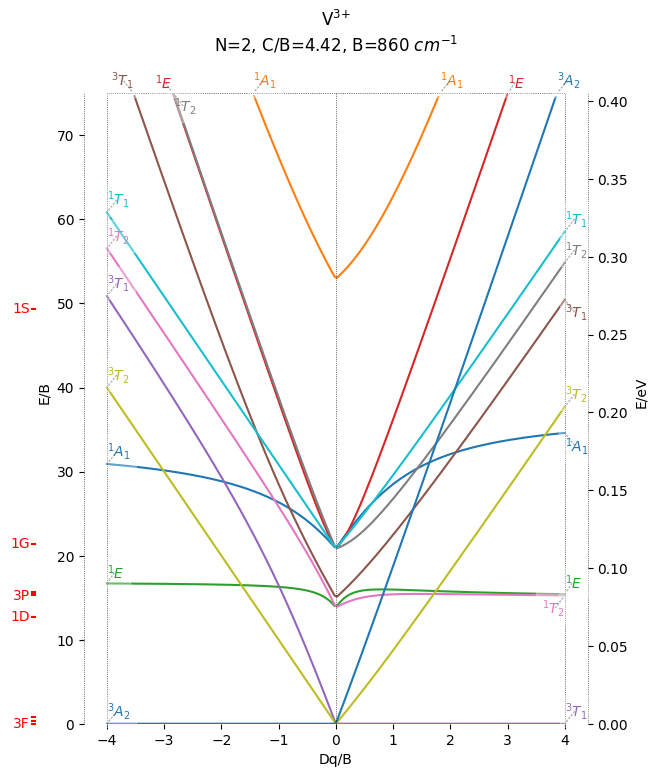

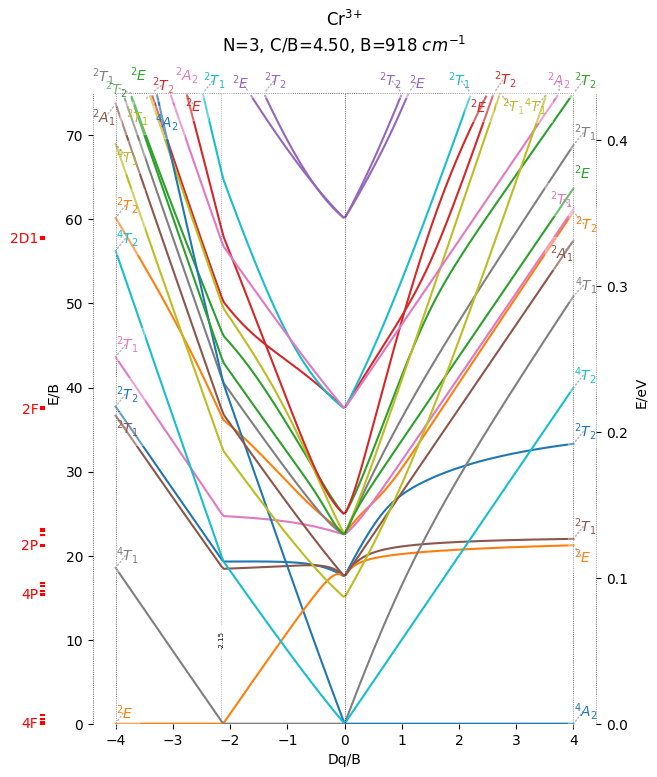

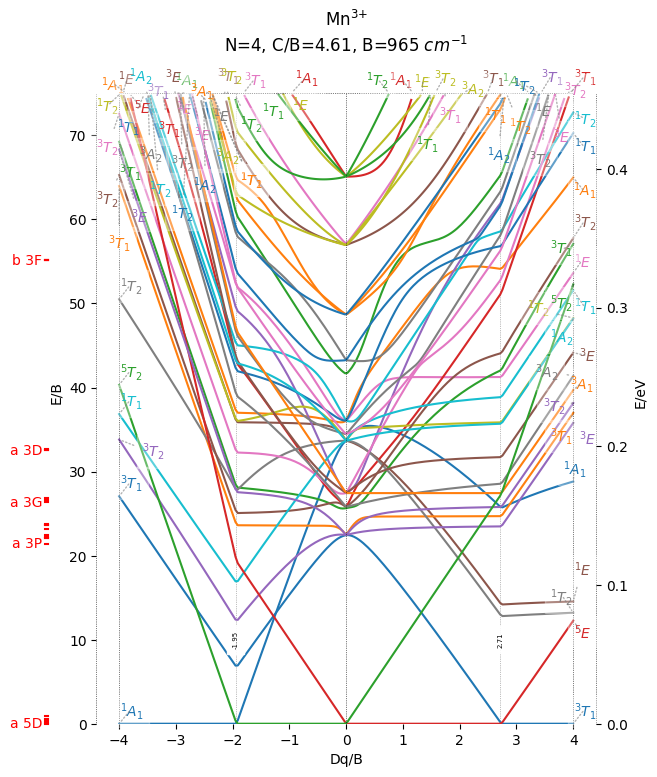

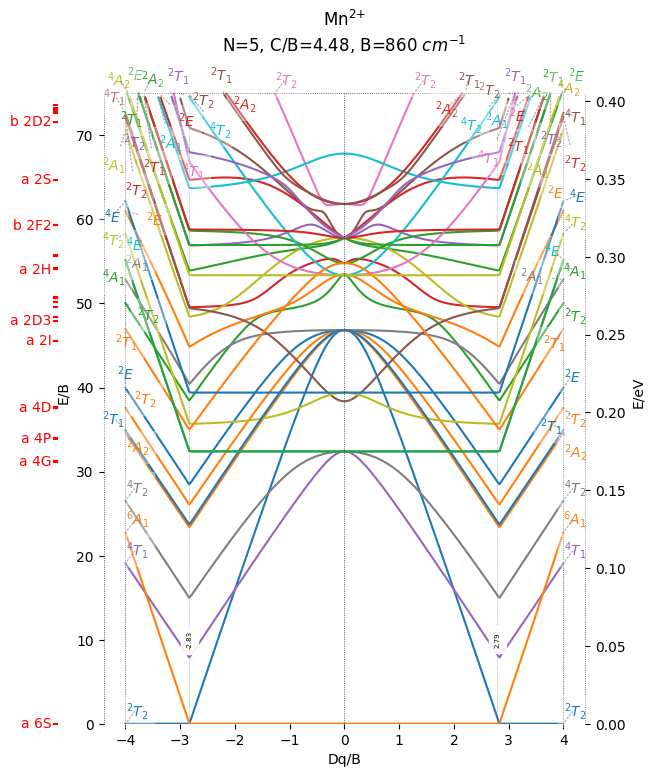

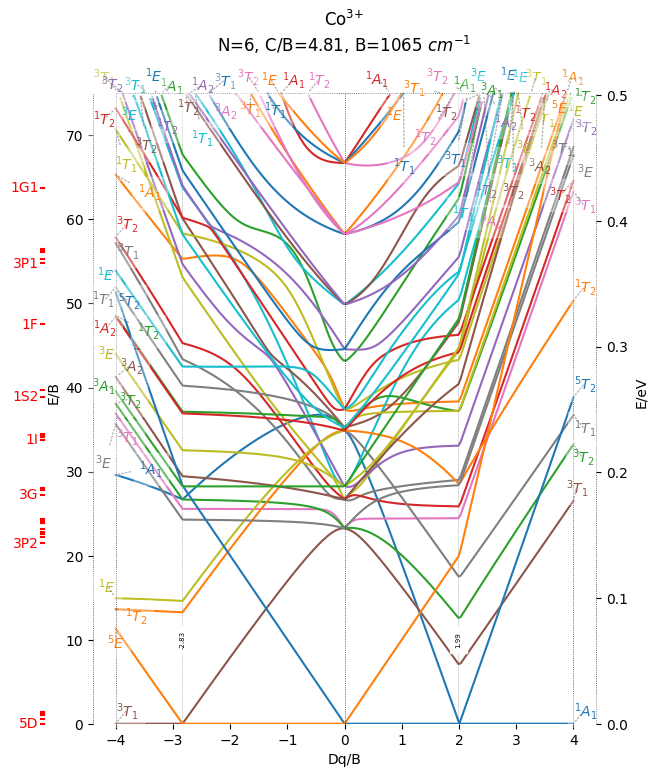

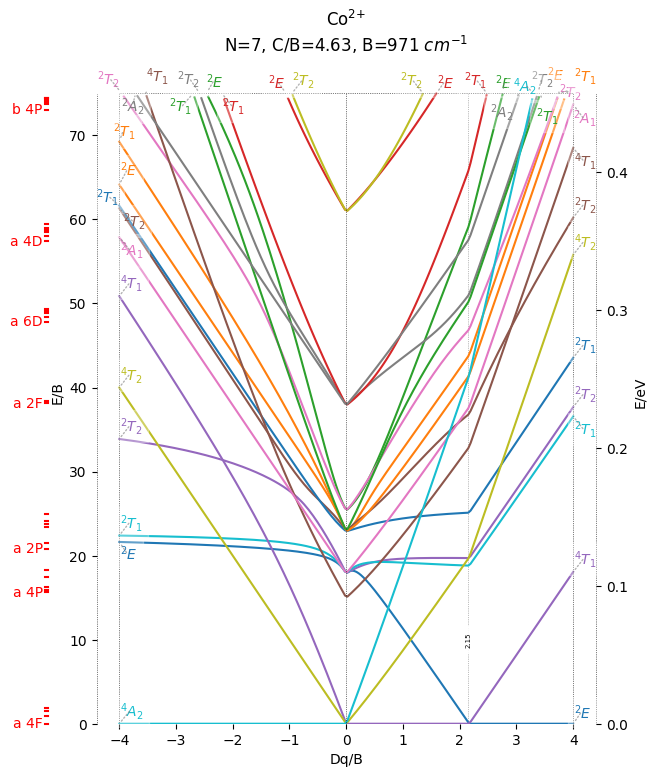

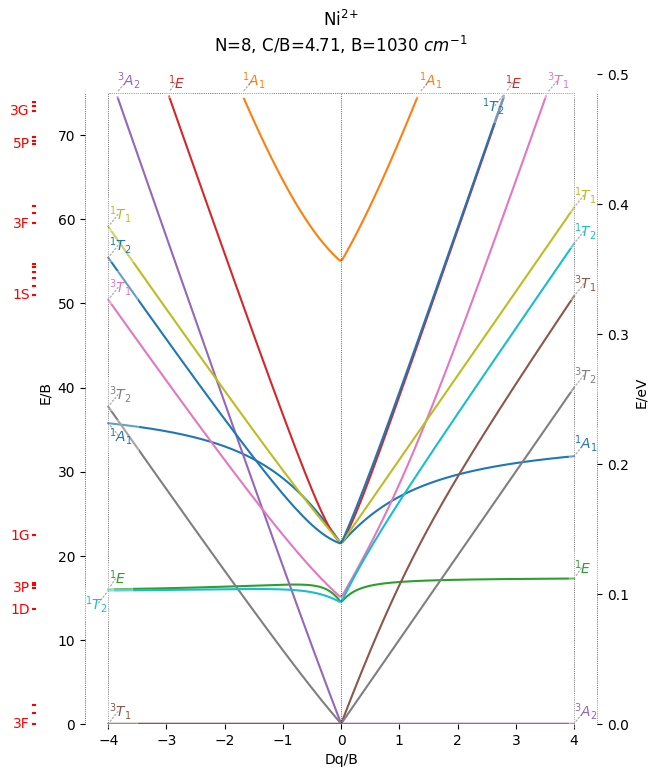

In [959]:
#1645044473
γexps = {2: 4.42, 3: 4.50, 4: 4.61, 5: 4.48, 6: 4.81, 7: 4.63, 8: 4.71}
Bexps =  {2: 860, 3:918 , 4:965 , 5:860, 6: 1065, 7: 971, 8:1030}
atoms = dict(zip([2,3,4,5,6,7,8], 'V,3 Cr,3 Mn,3 Mn,2 Co,3 Co,2 Ni,2'.split(' ')))
figsize = (17/2.54,20/2.54)
Dqs = np.linspace(-4,4,200)
ymax = 75
ymin = 0
Dqmax = np.max(Dqs)
Dqmin = np.min(Dqs)
for num_electrons in [2,3,4,5,6,7,8]:
    sol_matrices = all_all_terms[num_electrons]['solution']['full_matrices']
    γexp = γexps[num_electrons]
    Bexp = Bexps[num_electrons]
    atom = atoms[num_electrons].split(',')[0]
    charge_state =  int(atoms[num_electrons].split(',')[1])
    ion = Ion(atom, charge_state)

    exp_levels = ion.nist_data_levels['Level (eV)'] * UnitCon.con_factor('eV','cm^{-1}') / Bexp
    term_labels =  ion.nist_data_levels['Term']
    selector = exp_levels < ymax
    exp_levels = exp_levels[selector]
    term_labels = term_labels[selector]

    fig, ax = plt.subplots(figsize=figsize)
    energy_array = []
    min_energies = []
    cterm_labels = sum([['${}^%d{%s}$' % (tkey[0]*2+1, tkey[1])]*sol_matrices[tkey].rows for tkey in sol_matrices.keys()],[])
    cterm_mutiplicities = sum([[tkey[0]*2+1]*sol_matrices[tkey].rows for tkey in sol_matrices.keys()],[])
    switchboard = []
    for aDq in Dqs:
        energies = [list(np.linalg.eigvalsh(np.array( matrix.subs({sp.Symbol('\\gamma_{CB}'): γexp}).subs({Dq:aDq}),dtype=np.float64))) 
                    for matrix in sol_matrices.values()]
        all_energies = sum(energies,[])
        min_energy = min(all_energies)
        min_arg = np.argmin(np.array(all_energies))
        switchboard.append(min_arg)
        energy_array.append(sum(energies,[]))
        min_energies.append(min_energy)
    energy_array = np.array(energy_array).T
    min_energies = np.array(min_energies)
    rpivots = []
    dmin = 3
    texts = []
    tprops = dict(facecolor='w', alpha=0.3, edgecolor='w')
    tprops2 = dict(facecolor='w', alpha=0.9, edgecolor='w')
    lstyle = '-'
    switchjoints = [x for x in list(Dqs[(np.diff(switchboard,append=0) != 0)]) if np.abs(x)>0.2 and x not in [Dqmin, Dqmax]]
    for swj in switchjoints:
        ax.plot([swj,swj], [ymin,ymax], 'k:', alpha=0.5, lw=0.5)
        t = ax.text(swj, 10, '%.2f' % swj, rotation=90, bbox=tprops2, size=5, ha='center',va='center')
    for idx, row in enumerate(energy_array):
        men = row-min_energies
        the_label = cterm_labels[idx]
        multip = cterm_mutiplicities[idx]
        ax.plot(Dqs[men<=ymax], men[men<=ymax], label=the_label, linestyle=lstyle)
        col = ax.lines[-1].get_color()
        frame_type = ('r' if (men[-1]<ymax) else 't')
        if frame_type == 'r':
            loco = men[-1]
            t = ax.text(Dqmax, loco, the_label, c=col, ha='center', va='center', backgroundcolor='w', bbox=tprops)
            texts.append(t)
            rpivots.append(loco)
        elif frame_type == 't':
            # need to find where it hits the top part
            loco = np.interp(ymax,men[Dqs>0],Dqs[Dqs>0])
            if loco == Dqmin or abs(loco) < 0.1:
                continue
            t= ax.text(loco, ymax, the_label,c=col, ha='center', va='center', backgroundcolor='w', bbox=tprops)
            texts.append(t)
        frame_type = ('r' if (men[0]<ymax) else 't')
        if frame_type == 'r':
            loco = men[0]
            t = ax.text(Dqmin, loco, the_label, c=col, ha='right', va='center', backgroundcolor='w', bbox=tprops)
            texts.append(t)
            rpivots.append(loco)
        elif frame_type == 't':
            # need to find where it hits the top part
            loco = np.interp(ymax,men[Dqs<0][::-1],Dqs[Dqs<0][::-1])
            if abs(loco) < 0.1:
                continue
            t = ax.text(loco, ymax, the_label, c=col, ha='center', va='bottom', backgroundcolor='w', bbox=tprops)
            texts.append(t)
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', linestyle = ':', alpha=0.6))
    
    y_str = []
    first = True
    
    for exp_level, term_label in zip(exp_levels, term_labels):
        dx = -0.5
        line = plt.Line2D([-0.8+Dqmin+dx,-0.75+Dqmin+dx], [exp_level]*2, c='r')
        line.set_clip_on(False)
        ax.add_line(line)
        if (len(y_str)>0 and min(([abs(ys - exp_level) for ys in y_str])) > 2) or first:
            plt.text(-.85+Dqmin+dx, exp_level, term_label, ha='right', va='center', c='r')
            first = False
        y_str.append(exp_level)
    
    ax.set_ylim(ymin,ymax+4)
    ax.set_xlim(Dqmin-0.4,Dqmax+0.4)
    ax.set_xlabel('Dq/B')
    ax.set_ylabel('E/B')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    axright = ax.twinx()  # instantiate a second axes that shares the same x-axis
    axright.set_ylim(ymin*Bexp*UnitCon.con_factor('cm^{-1}','eV'), Dqmax*Bexp*UnitCon.con_factor('cm^{-1}','eV'))
    axright.set_ylabel('E/eV')
    axright.spines['top'].set_visible(False)
    axright.spines['right'].set_visible(False)
    axright.spines['bottom'].set_visible(False)
    axright.spines['left'].set_visible(False)
    ax.set_title('%s${}^{%d\!+}$\nN=%d, C/B=%.2f, B=%.0f $cm^{-1}$' % (atom, charge_state, num_electrons, γexp, Bexp))
    ax.plot([Dqmin,Dqmin,Dqmax,Dqmax],[ymin,ymax,ymax,ymin],'k:',lw=0.5)
    ax.plot([Dqmax+0.4,Dqmax+0.4],[ymin,ymax],'k:',lw=0.5, clip_on = False)
    ax.plot([0,0],[ymin,ymax],'k:',lw=0.5, clip_on = False)
    ax.plot([Dqmin-0.4,Dqmin-0.4],[ymin,ymax],'k:',lw=0.5, clip_on = False)
    plt.tight_layout()
    plt.savefig('./images/TSK-GT-%d.pdf' % num_electrons)
    plt.show()
    # if num_electrons == 3:
    #     break

In [ ]:
    
    for term_key, matrix in all_terms['solution']['matrices'].items():

        row_energies = [(-4*c[(sp.Symbol('T_2'))] + 6*c[(sp.Symbol('E'))])*Dq for c in electron_counter]
        energy_term = sp.diag(*row_energies)
        full_energy_matrix = matrix + energy_term
        full_energy_matrix = full_energy_matrix.subs({sp.Symbol('C'):sp.Symbol('\\gamma_{CB}'), sp.Symbol('B'):1})
        if verbose:
            display(term_symbol)
            display(full_matrix)
        all_terms['solution']['full_matrices'][term_key] = full_energy_matrix

In [917]:
!cp ./calculations/all_terms.pkl ./calculations/all_terms-backup.pkl

In [916]:
#1645044557
# create latex output
# section label
# figure with caption
# coulomb repulsion matrices
tex_output_lines = []
l = 2
for num_electrons in range(2,9):
    sol_matrices = all_all_terms[num_electrons]['solution']['matrices']
    figsize = 0.95
    if num_electrons == 2:
        figsize = 0.8
    if num_electrons != 2:
        line = '\\newpage\n\\section{$d^%d$}\n' % num_electrons
    else:
        line = '\\section{$d^%d$}\n' % num_electrons
    tex_output_lines.append(line)
    LScterms = LS_terms_in_crystal_terms('O', l, num_electrons)
    line = '''\\begin{figure}[ht!]
\\centering
\\includegraphics[width=%.1f\\textwidth]{./img/TSK-GT-%d.pdf}
\\end{figure}
\\newpage''' % (figsize, num_electrons)
    all_terms = all_all_terms[num_electrons]
    tex_output_lines.append(line)
    if num_electrons in [4,5,6]:
        tex_output_lines.append('\\begin{landscape}')
    for term_key, matrix in sol_matrices.items():
        term_symbol = sp.Symbol('{}^%d{%s}' %(term_key[0]*2+1, term_key[1]))
        LSterms = LScterms[(term_key[0]*2+1, term_key[1])]
        LSterms = ','.join(sorted(LSterms.elements()))
        LSterms = '(%s)' % LSterms
        term_symbol = sp.Symbol(str(term_symbol) + LSterms)
        electron_counter = [Counter(psi.electrons) for psi in all_terms['all_terms'][term_key]]
        matrix_headers = [make_multi_term_symbol(psi_key) for psi_key in all_terms['all_terms'][term_key]]
        matrix_headers = sp.Matrix(matrix_headers).T
        row_energies = [(-4*c[(sp.Symbol('T_2'))] + 6*c[(sp.Symbol('E'))])*Dq for c in electron_counter]
        energy_term = sp.diag(*row_energies)
        full_energy_matrix = matrix + energy_term
        full_matrix = sp.Matrix(sp.BlockMatrix([[matrix_headers],[full_energy_matrix]]))
        matrix_latex = '''\\begin{equation}
\\tiny
%s
\\end{equation}\n''' % sp.latex(full_matrix)
        term_line = '\\centerline{$%s$}\n' % sp.latex(term_symbol)
        tex_output_lines.append(term_line)
        tex_output_lines.append(matrix_latex)
    if num_electrons in [4,5,6]:
        tex_output_lines.append('\\end{landscape}')
tex_output = '\n'.join(tex_output_lines)
open('/Users/juan/Library/Mobile Documents/com~apple~CloudDocs/iCloudFiles/Theoretical Division/TSK-diag.tex','w').write(tex_output)

25896

In [818]:
!open .

In [534]:
num_electrons = 3
l = 3
allowed_LS_terms = LS_allowed_terms(l, num_electrons)
Ls = range(0,l*num_electrons+1)
reduction = {}
for L in Ls:
    the_split = l_splitter('O',L)
    the_big_term = l_from_num_to_lett[L].upper()
    for split_irrep, count in the_split.dict.items():
        if split_irrep not in reduction:
            reduction[split_irrep] = []
        reduction[split_irrep].append(the_big_term)
spin_reduction = {}
for mult, Ls in allowed_LS_terms.items():
    for irrep, cterms in reduction.items():
        inters = [c for c in Ls if c in cterms]
        if len(inters) > 0:
            spin_reduction[(mult,irrep)] = inters


In [549]:
def LS_terms_in_crystal_terms(group_label, l, num_electrons):
    allowed_LS_terms = LS_allowed_terms(l, num_electrons)
    Ls = range(0,l*num_electrons+1)
    reduction = {}
    for L in Ls:
        the_split = l_splitter(group_label,L)
        the_big_term = l_from_num_to_lett[L].upper()
        for split_irrep, count in the_split.dict.items():
            if split_irrep not in reduction:
                reduction[split_irrep] = []
            reduction[split_irrep].append(the_big_term)
    spin_reduction = {}
    for mult, Ls in allowed_LS_terms.items():
        for irrep, cterms in reduction.items():
            inters = [c for c in Ls if c in cterms]
            if len(inters) > 0:
                spin_reduction[(mult,irrep)] = Counter(inters)
    return spin_reduction


In [550]:
LS_terms_in_crystal_terms('O', 2, 4)

{(1, A_1): Counter({'I': 1, 'G': 2, 'S': 2}),
 (1, T_1): Counter({'I': 1, 'G': 2, 'F': 1}),
 (1, E): Counter({'I': 1, 'G': 2, 'D': 2}),
 (1, T_2): Counter({'I': 1, 'G': 2, 'F': 1, 'D': 2}),
 (1, A_2): Counter({'I': 1, 'F': 1}),
 (3, A_1): Counter({'G': 1}),
 (3, T_1): Counter({'H': 1, 'G': 1, 'F': 2, 'P': 2}),
 (3, E): Counter({'H': 1, 'G': 1, 'D': 1}),
 (3, T_2): Counter({'H': 1, 'G': 1, 'F': 2, 'D': 1}),
 (3, A_2): Counter({'F': 2}),
 (5, E): Counter({'D': 1}),
 (5, T_2): Counter({'D': 1})}

## Big export (cubic_ions_HF.h5) : compute TSK-like data for all ions using HF approx. (Feb-27 2022-02-27 11:18:07)

Now that I'm including spin-orbit, I need to go back to diagonalizing the full hamiltonian in the uncoupled basis.

In [17]:
import pandas as pd

In [18]:
hf_free_ions = pd.read_pickle('./data/brik_ma_cowan.pkl')

In [ ]:
Dqs = np.linspace(0,5,100) # Dq/B
Dq = sp.Symbol('Dq')
l = 2
tutti_eigensys = OrderedDict()
for index, row in hf_free_ions.iterrows():
    num_electrons = row['ndN']
    ion = Ion(row['Element'], row['Charge'])
    print(row['Element'], row['Charge'], end='|')
    B, C = row['B/cm^-1'], row['C/cm^-1']
    F2 = 49*B + 7*C
    F4 = 63*C/5
    α = 0.
    ζ = row['ζd/cm^-1']
    dζ = 1
    dα = 0.
    if any(list(map(np.isnan, [B,C,F2,F4,α]))):
        tutti_eigensys[index] = None
    else:
        ham = hamiltonian_CF_CR_SO_TO(num_electrons, 'O', l, False, True)
        matrixmah = ham[0].subs({sp.Symbol('B_{4,0}'): 21*Dq, sp.Symbol('F^{(0)}'): 0})
        subs = {
                sp.Symbol('F^{(2)}'): F2,
                sp.Symbol('F^{(4)}'): F4,
                sp.Symbol('\\alpha_T'): α,
                sp.Symbol('\\zeta_{SO}'): ζ
                }
        matrixmah = matrixmah.subs(subs)
        mfun = sp.lambdify(Dq,matrixmah)
        eigensystems = []
        for aDq in Dqs:
            nummatrix = mfun(aDq*B)
            nummatrix = np.array(nummatrix, dtype=np.float64)
            eigensys = np.linalg.eigh(nummatrix)
            eigensystems.append(eigensys)
        tutti_eigensys[index] = (eigensystems)

In [82]:
pickle.dump(tutti_eigensys, open('./data/tutti.pkl','wb'))

In [20]:
hf_free_ions

,Element,Charge,n,ndN,A/cm^-1,B/cm^-1,C/cm^-1,C/B,E_avg/cm^-1,EI/cm^-1,ζd/cm^-1,r^2/Å^2,r^4/Å^4,Z
0,Sc,2,3,1,NaN,NaN,NaN,NaN,NaN,24.58,90.31,0.80788,1.41855,21
1,Ti,2,3,2,139887.0,892.10,3296.12,3.69481,141063.0,25.95,131.66,0.69447,1.08136,22
2,V,2,3,3,151916.0,967.75,3573.18,3.69225,459569.0,28.08,184.47,0.59226,0.79906,23
3,Cr,2,3,4,163479.0,1040.04,3837.10,3.68937,989073.0,30.09,249.84,0.51469,0.61251,24
4,Mn,2,3,5,174732.0,1110.12,4092.50,3.68652,1761882.0,32.00,329.57,0.45365,0.48257,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Tl,7,5,6,156150.0,1106.00,4671.77,4.22401,948379.0,116.46,9352.60,0.46653,0.32778,81
178,Pb,7,5,7,160371.0,1134.46,4790.92,4.22308,486998.0,119.99,10240.50,0.44273,0.29571,82
179,Bi,7,5,8,164586.0,1162.87,4909.87,4.22220,166596.0,123.50,11186.95,0.42060,0.26748,83
180,Po,7,5,9,168795.0,1191.22,5028.57,4.22135,NaN,126.99,12195.29,0.40016,0.24270,84


Sc 2|Ti 2|

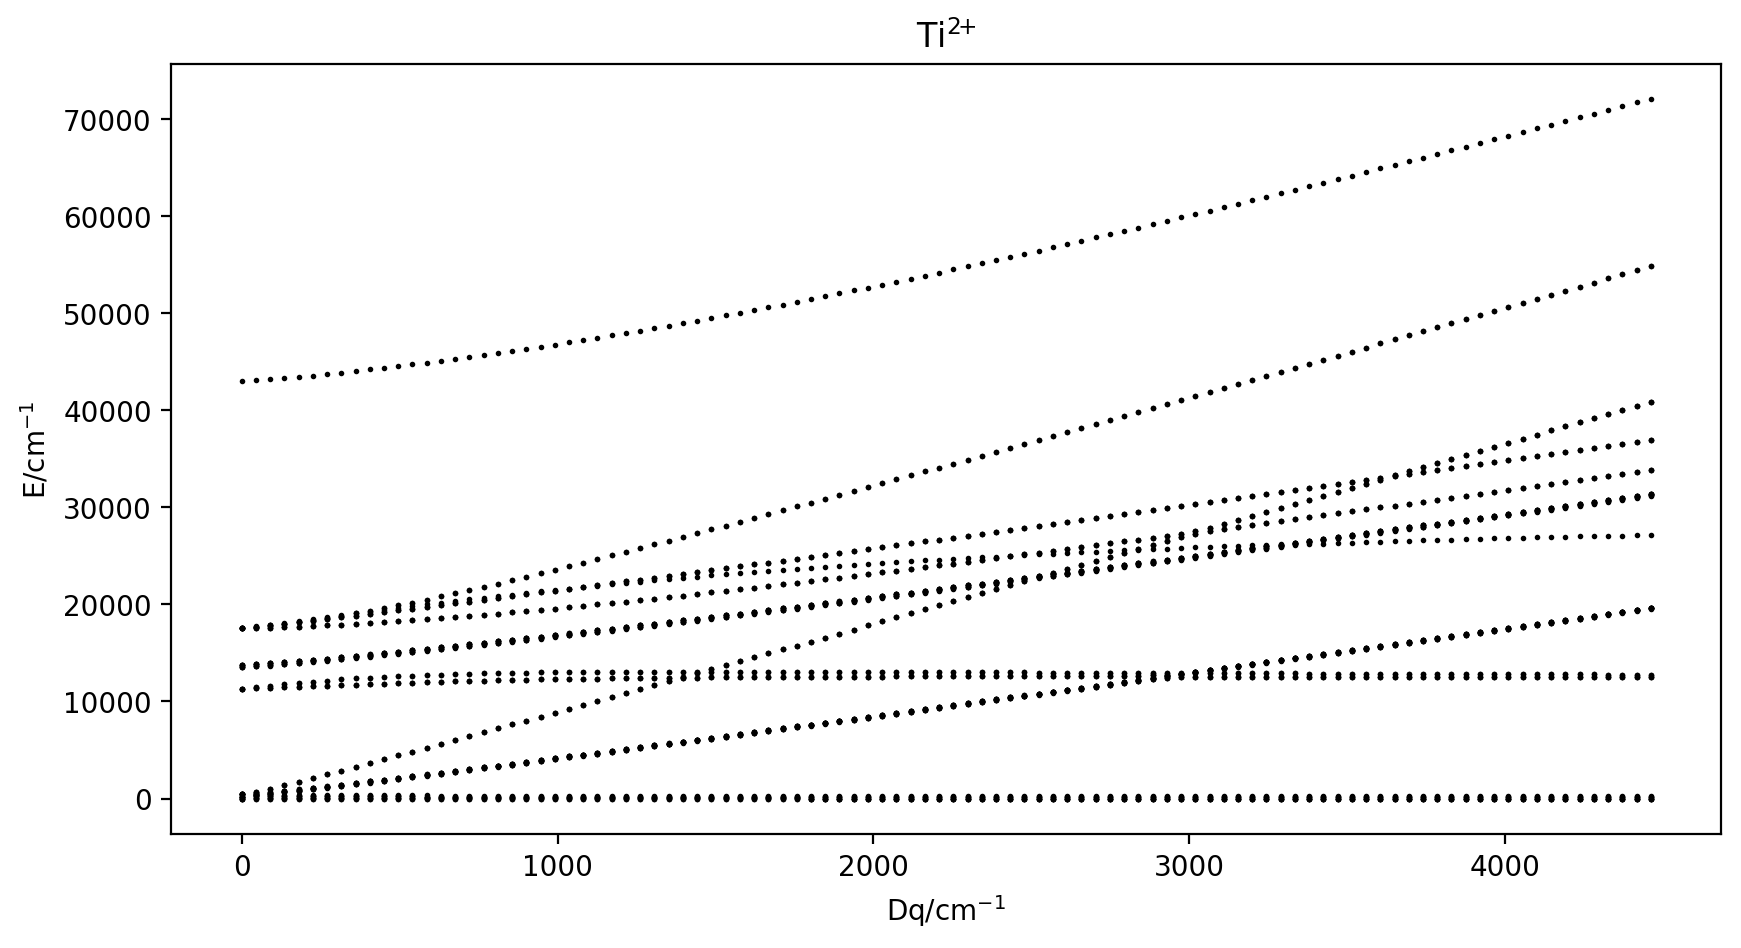

In [114]:
for index, row in hf_free_ions.iterrows():
    num_electrons = row['ndN']
    ion = Ion(row['Element'], row['Charge'])
    print(row['Element'], row['Charge'], end='|')
    eigensys = tutti_eigensys[index]
    B, C = row['B/cm^-1'], row['C/cm^-1']
    if eigensys:
        eigenvals = [e[0] for e in eigensys]
        title = '%s${}^{%s\!\!+}$' % (ion.symbol, ion.charge_state)
        fig, ax = plt.subplots(figsize=(10,5))
        for row, aDq in zip(eigenvals, Dqs):
            row = row-np.min(row)
            ax.plot([aDq*B]*len(row), row, 'ko',ms=1)
        ax.set_xlabel('Dq/cm${}^{-1}$')
        ax.set_ylabel('E/cm${}^{-1}$')
        ax.set_title(title)
        plt.show()
    if index == 1:
        break
        

In [ ]:

for num_electrons in gamma_arrays:
    h5_file.create_dataset('%d' % num_electrons, data = gamma_arrays[num_electrons])
    h5_file.create_dataset('%d-labels' % num_electrons, data = all_cterm_labels[num_electrons])
h5_file.create_dataset('Dqs', data = Dqs)
h5_file.create_dataset('gammas', data = γs)
h5_file.close()

Sc 2|Ti 2|

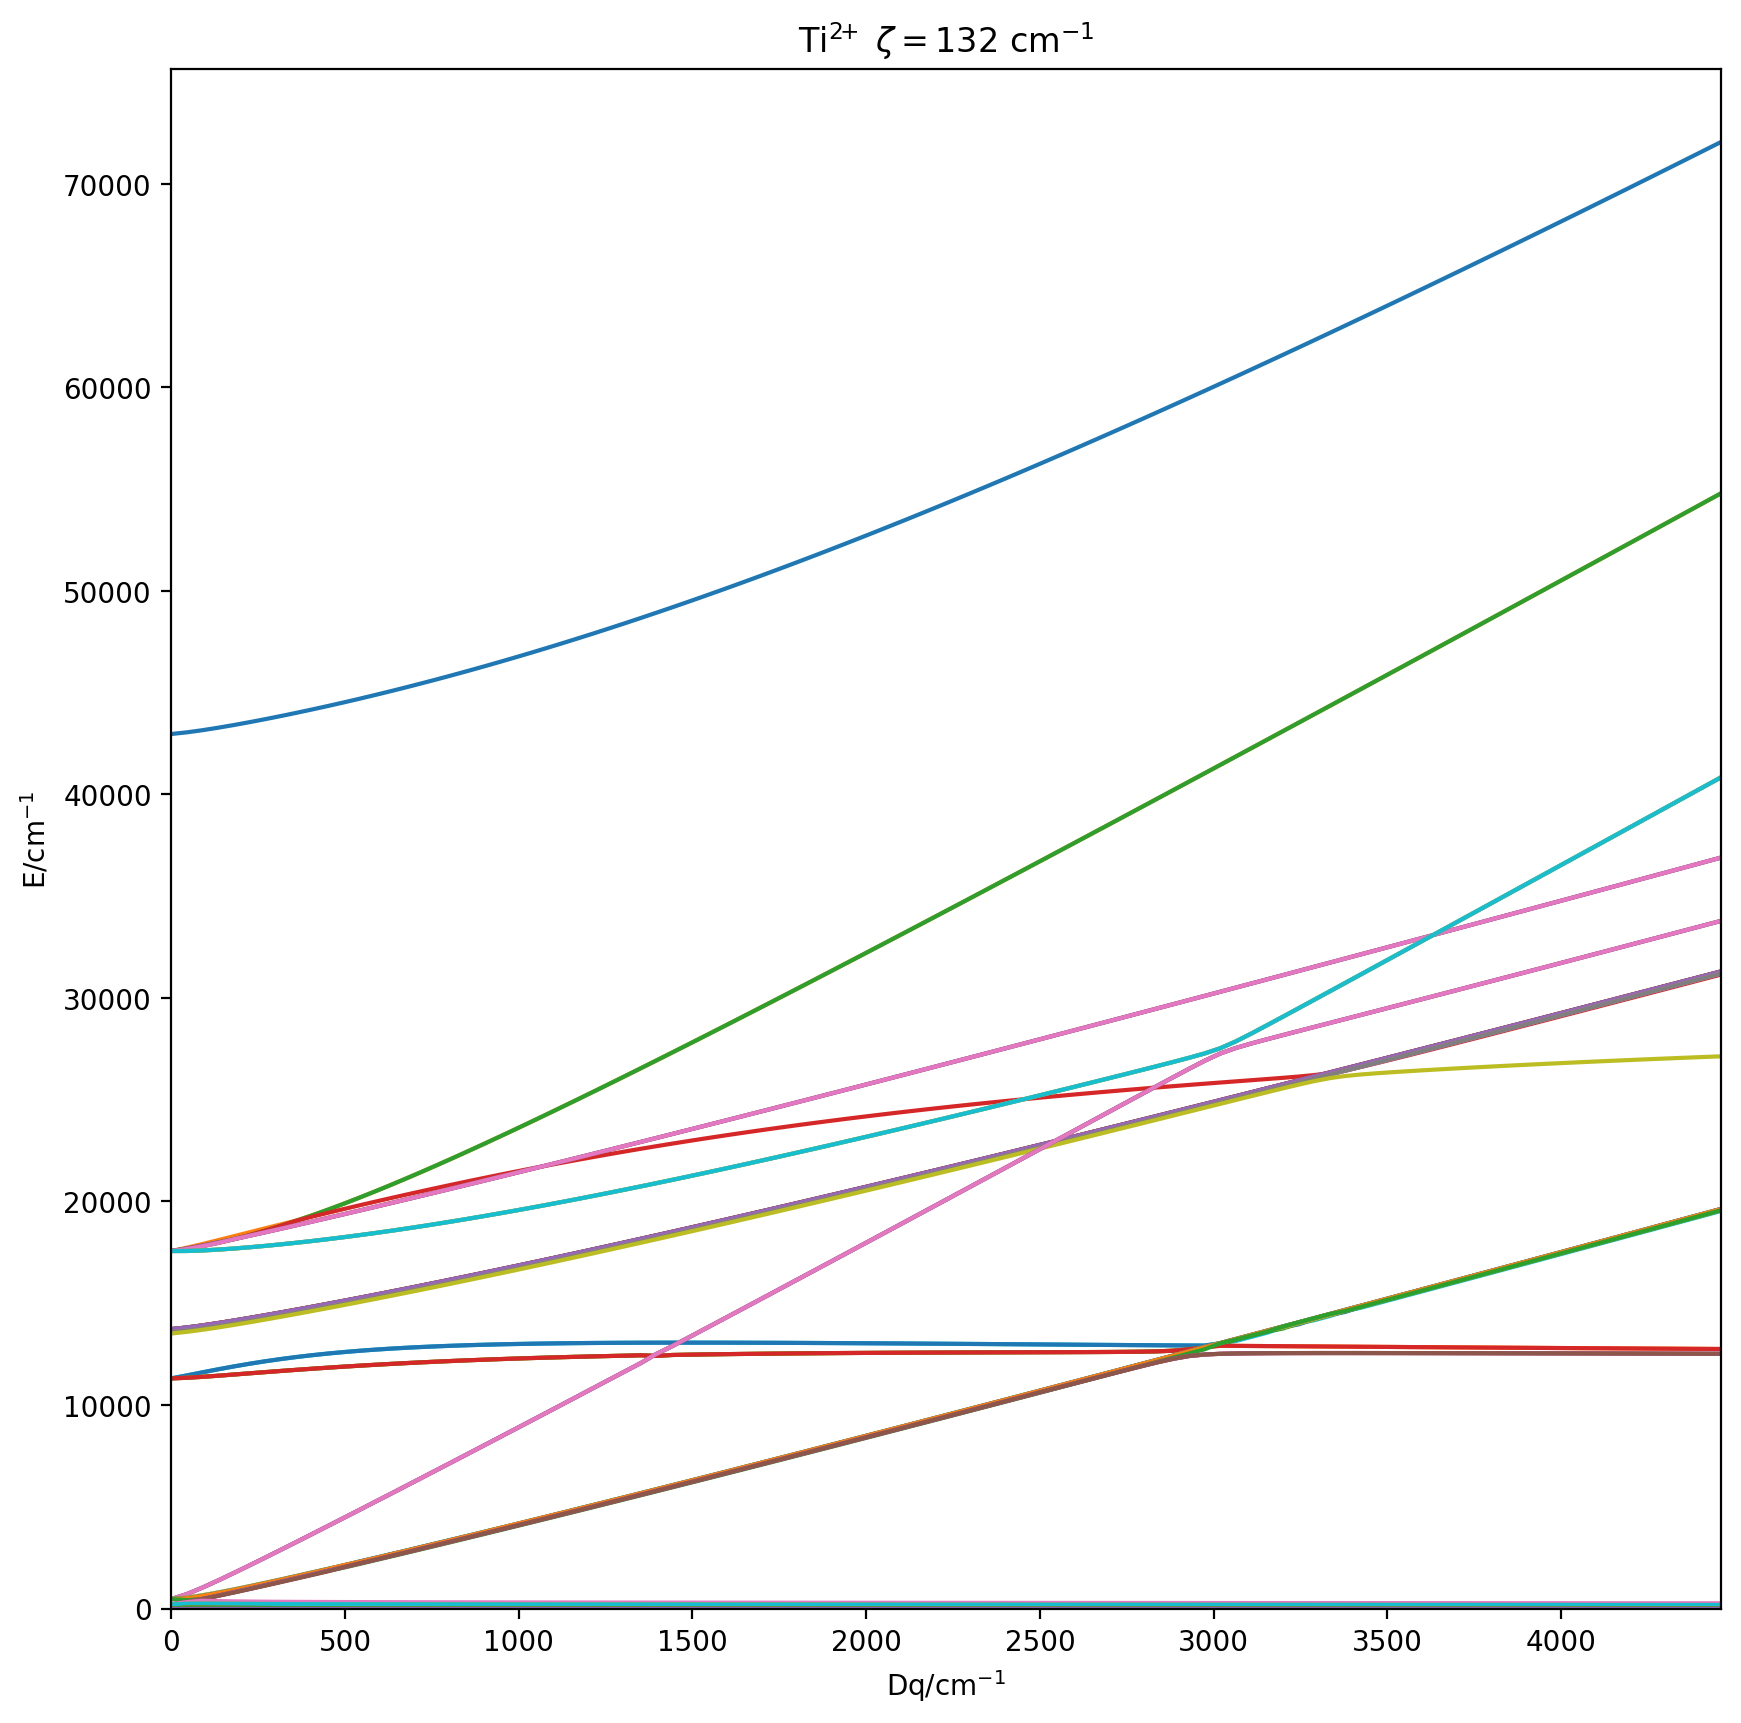

In [148]:
for index, row in hf_free_ions.iterrows():
    num_electrons = row['ndN']
    ion = Ion(row['Element'], row['Charge'])
    print(row['Element'], row['Charge'], end='|')
    eigensys = tutti_eigensys[index]
    B, C = row['B/cm^-1'], row['C/cm^-1']
    ζ = row['ζd/cm^-1']
    if eigensys:
        eigenvals = np.array([e[0] - np.min(e[0]) for e in eigensys])
        eigenvals = eigenvalue_disambiguate(np.fliplr(eigenvals))
        # eigenvals = np.fliplr(eigenvals)
        # eigenvals = eigenvals
        title = '%s${}^{%s\!\!+}$ $\\zeta=%.0f$ cm${}^{-1}$' % (ion.symbol, ion.charge_state, ζ)
        fig, ax = plt.subplots(figsize=(10,10))
        for row in eigenvals:
            ax.plot(Dqs*B, row, '-',ms=1)
        ax.set_xlabel('Dq/cm${}^{-1}$')
        ax.set_ylabel('E/cm${}^{-1}$')
        ax.set_title(title)
        ax.set_xlim(left=0, right=Dqs[-1]*B)
        ax.set_ylim(bottom=0)
        plt.show()
    if index == 1:
        break
        

In [ ]:

# for num_electrons in gamma_arrays:
#     h5_file.create_dataset('%d' % num_electrons, data = gamma_arrays[num_electrons])
#     h5_file.create_dataset('%d-labels' % num_electrons, data = all_cterm_labels[num_electrons])
# h5_file.create_dataset('Dqs', data = Dqs)
# h5_file.create_dataset('gammas', data = γs)
# h5_file.close()

# import h5py
# h5_file = h5py.File('free_ion_HF.h5','w')
# for index in nonz:
#     row = hf_free_ions.iloc[index]
#     transitions = all_transitions[index]
#     waves = [transition['wavelength/m'].nominal_value for transition in transitions]
#     rates = [transition['rate/Hz'] for transition in transitions]
#     waves_address = '/%s/%d/waves' % (row['Element'], row['Charge']) 
#     rates_address = '/%s/%d/rates' % (row['Element'], row['Charge']) 
#     h5_file.create_dataset(waves_address, data = waves)
#     h5_file.create_dataset(rates_address, data = rates)
# h5_file.close()

In [152]:
import h5py

In [172]:
h5_file = h5py.File('./data/tsk_diag_withSO_HF.h5','w')
Dqs_ratio = np.linspace(0,5,100)
for index, row in hf_free_ions.iterrows():
    num_electrons = row['ndN']
    ion = Ion(row['Element'], row['Charge'])
    print(row['Element'], row['Charge'], end='|')
    eigensys = tutti_eigensys[index]
    B, C = row['B/cm^-1'], row['C/cm^-1']
    ζ = row['ζd/cm^-1']
    ionDqs = Dqs_ratio*B
    if eigensys:
        eigenvals = np.array([e[0] - np.min(e[0]) for e in eigensys])
        eigenvals = eigenvalue_disambiguate(np.fliplr(eigenvals))
        energy_address = '/%s/%d/energies' % (ion.symbol, ion.charge_state)
        h5_file.create_dataset(energy_address, data = eigenvals)
        Dqs_address = '/%s/%d/Dqs' % (ion.symbol, ion.charge_state)
        h5_file.create_dataset(Dqs_address, data = ionDqs)
h5_file.close()

Sc 2|Ti 2|V 2|Cr 2|Mn 2|Fe 2|Co 2|Ni 2|Cu 2|Zn 2|Ti 3|V 3|Cr 3|Mn 3|Fe 3|Co 3|Ni 3|Cu 3|Zn 3|Ga 3|V 4|Cr 4|Mn 4|Fe 4|Co 4|Ni 4|Cu 4|Zn 4|Ga 4|Ge 4|Y 2|Zr 2|Nb 2|Mo 2|Tc 2|Ru 2|Rh 2|Pd 2|Ag 2|Cd 2|Y 3|Zr 3|Nb 3|Mo 3|Tc 3|Ru 3|Rh 3|Pd 3|Ag 3|Cd 3|In 3|Zr 4|Nb 4|Mo 4|Tc 4|Ru 4|Rh 4|Pd 4|Ag 4|Cd 4|In 4|Lu 2|Hf 2|Ta 2|W 2|Re 2|Os 2|Ir 2|Pt 2|Au 2|Hg 2|Lu 3|Hf 3|Ta 3|W 3|Re 3|Os 3|Ir 3|Pt 3|Au 3|Hg 3|Tl 3|Hf 4|Ta 4|W 4|Re 4|Os 4|Ir 4|Pt 4|Au 4|Hg 4|Tl 4|Cr 5|Mn 5|Fe 5|Co 5|Ni 5|Cu 5|Zn 5|Ga 5|Ge 5|As 5|Mn 6|Fe 6|Co 6|Ni 6|Cu 6|Zn 6|Ga 6|Ge 6|As 6|Se 6|Fe 7|Co 7|Ni 7|Cu 7|Zn 7|Ga 7|Ge 7|As 7|Se 7|Br 7|Mo 5|Tc 5|Ru 5|Rh 5|Pd 5|Ag 5|Cd 5|In 5|Sn 5|Sb 5|Tc 6|Ru 6|Rh 6|Pd 6|Ag 6|Cd 6|In 6|Sn 6|Sb 6|Te 6|Ru 7|Rh 7|Pd 7|Ag 7|Cd 7|In 7|Sn 7|Sb 7|Te 7|I 7|W 5|Re 5|Os 5|Ir 5|Pt 5|Au 5|Hg 5|Tl 5|Pb 5|Bi 5|Re 6|Os 6|Ir 6|Pt 6|Au 6|Hg 6|Tl 6|Pb 6|Bi 6|Po 6|Os 7|Ir 7|Pt 7|Au 7|Hg 7|Tl 7|Pb 7|Bi 7|Po 7|At 7|

In [6]:
hf_free_ions = pd.read_pickle('./data/brik_ma_cowan.pkl')

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


In [9]:
hf_free_ions[hf_free_ions['Z']<25]

,Element,Charge,n,ndN,A/cm^-1,B/cm^-1,C/cm^-1,C/B,E_avg/cm^-1,EI/cm^-1,ζd/cm^-1,r^2/Å^2,r^4/Å^4,Z
0,Sc,2,3,1,NaN,NaN,NaN,NaN,NaN,24.58,90.31,0.80788,1.41855,21
1,Ti,2,3,2,139887.0,892.10,3296.12,3.69481,141063.0,25.95,131.66,0.69447,1.08136,22
2,V,2,3,3,151916.0,967.75,3573.18,3.69225,459569.0,28.08,184.47,0.59226,0.79906,23
3,Cr,2,3,4,163479.0,1040.04,3837.10,3.68937,989073.0,30.09,249.84,0.51469,0.61251,24
10,Ti,3,3,1,NaN,NaN,NaN,NaN,NaN,43.39,164.18,0.51805,0.54499,22
11,V,3,3,2,167896.0,1094.59,4095.57,3.74165,169379.0,44.98,222.18,0.46345,0.44783,23
12,Cr,3,3,3,178875.0,1162.95,4343.87,3.73522,541334.0,47.61,293.69,0.41136,0.35781,24
20,V,4,3,1,NaN,NaN,NaN,NaN,NaN,65.64,261.76,0.37860,0.27955,23
21,Cr,4,3,2,192491.0,1271.99,4798.07,3.77210,194244.0,67.58,339.72,0.34500,0.23737,24
92,Cr,5,3,1,NaN,NaN,NaN,NaN,NaN,91.19,388.27,0.29487,0.16507,24


In [173]:
!beep

In [163]:
h5_file.close()

In [ ]:
# if os.path.exists('./data/hf_free_ion_calcs.pkl'):
#     hf_free_ions = pickle.load(open('./data/hf_free_ion_calcs.pkl','rb'))
# else:
#     all_energies = []
#     all_eigenqets = []
#     all_eigenvects = []
#     l = 2
#     for index, row in hf_free_ions.iterrows():
#         num_electrons = row['ndN']
#         ion = Ion(row['Element'], row['Charge'])
#         print(row['Element'], row['Charge'], end='|')
#         B, C = row['B/cm^-1'], row['C/cm^-1']
#         F2 = 49*B + 7*C
#         F4 = 63*C/5
#         α = 0.
#         ζ = row['ζd/cm^-1']
#         dζ = 1
#         dα = 0.
#         ham = hamiltonian_CF_CR_SO_TO(num_electrons, 'O', l, False, True)
#         matrixmah = ham[0].subs({sp.Symbol('B_{4,0}'): 0, sp.Symbol('F^{(0)}'): 0})
#         vars = OrderedDict([
#             (sp.Symbol('F^{(2)}'), ufloat(F2, 1)),
#             (sp.Symbol('F^{(4)}'), ufloat(F4, 1)),
#             (sp.Symbol('\\alpha_T'), ufloat(α, dα)),
#             (sp.Symbol('\\zeta_{SO}'), ufloat(ζ, dζ))])
#         eigenvals = uncertain_eigenvalsh(matrixmah, vars, 100)
#         best_estimate_ham = matrixmah.subs({k: v.nominal_value for k,v in vars.items()})
#         best_estimate_ham = np.array(best_estimate_ham, dtype=np.complex64)
#         eigenvects = np.linalg.eigh(best_estimate_ham)
#         all_eigenvects.append(eigenvects[1].T)
#         eigenqets = [Qet({k:v for k,v in zip(ham[-1],row)}) for row in (eigenvects[1].T)]
#         all_eigenqets.append(eigenqets)
#         energies = eigenvals - min(eigenvals)
#         all_energies.append(energies)
#     hf_free_ions['Energy Levels / cm^{-1}'] = all_energies
#     hf_free_ions['Eigenqets'] = all_eigenqets
#     hf_free_ions['Eigenvectors'] = all_eigenvects
#     hf_free_ions.sort_values(['Z','Charge'], 0, inplace=True)

In [ ]:
# gamma_arrays = {}
# Dqs=np.array(sum([list(np.linspace(-100,-10,10))[:-1],
#                   list(np.linspace(-10,10,401)),
#                   list(np.linspace(10,100,10))[1:]],[]))
# γs = np.linspace(3,6,31)
# all_cterm_labels = {}
# for num_electrons in range(1,6):
#     # if num_electrons in gamma_arrays:
#     #     continue
#     print(num_electrons)
#     all_terms = all_all_terms[num_electrons]
#     sol_matrices = all_terms['solution']['full_matrices']
#     gamma_array = []
#     for γexp in γs:
#         energy_array = []
#         min_energies = []
#         cterm_labels = sum([['${}^%d{%s}$' % (tkey[0]*2+1, tkey[1])]*sol_matrices[tkey].rows for tkey in sol_matrices.keys()],[])
#         cterm_labels = sum([['%d,%s' % (tkey[0]*2+1, tkey[1])]*sol_matrices[tkey].rows for tkey in sol_matrices.keys()],[])
#         for aDq in Dqs:
#             energies = [list(np.linalg.eigvalsh(np.array( matrix.subs({sp.Symbol('\\gamma_{CB}'): γexp}).subs({Dq:aDq}),dtype=np.float64))) 
#                         for matrix in sol_matrices.values()]
#             all_energies = sum(energies,[])
#             min_energy = min(all_energies)
#             min_arg = np.argmin(np.array(all_energies))
#             energy_array.append(sum(energies,[]))
#             min_energies.append(min_energy)
#         energy_array = np.array(energy_array).T
#         min_energies = np.array(min_energies)
#         gamma_array.append(energy_array-min_energies)
#     gamma_array = np.array(gamma_array)
#     all_cterm_labels[num_electrons] = cterm_labels
#     gamma_arrays[num_electrons] = gamma_array
# h5_file = h5py.File('tsk_diag.h5','w')
# for num_electrons in gamma_arrays:
#     h5_file.create_dataset('%d' % num_electrons, data = gamma_arrays[num_electrons])
#     h5_file.create_dataset('%d-labels' % num_electrons, data = all_cterm_labels[num_electrons])
# h5_file.create_dataset('Dqs', data = Dqs)
# h5_file.create_dataset('gammas', data = γs)
# h5_file.close()

1
2
3
4
5


## Big export (tsk_diag.h5) : compute TSK data for range of values for B/C and Dq

In [ ]:
import h5py

In [1216]:
gamma_arrays = {}
Dqs=np.array(sum([list(np.linspace(-100,-10,10))[:-1],
                  list(np.linspace(-10,10,401)),
                  list(np.linspace(10,100,10))[1:]],[]))
γs = np.linspace(3,6,31)
all_cterm_labels = {}
for num_electrons in range(1,6):
    # if num_electrons in gamma_arrays:
    #     continue
    print(num_electrons)
    all_terms = all_all_terms[num_electrons]
    sol_matrices = all_terms['solution']['full_matrices']
    gamma_array = []
    for γexp in γs:
        energy_array = []
        min_energies = []
        cterm_labels = sum([['${}^%d{%s}$' % (tkey[0]*2+1, tkey[1])]*sol_matrices[tkey].rows for tkey in sol_matrices.keys()],[])
        cterm_labels = sum([['%d,%s' % (tkey[0]*2+1, tkey[1])]*sol_matrices[tkey].rows for tkey in sol_matrices.keys()],[])
        for aDq in Dqs:
            energies = [list(np.linalg.eigvalsh(np.array( matrix.subs({sp.Symbol('\\gamma_{CB}'): γexp}).subs({Dq:aDq}),dtype=np.float64))) 
                        for matrix in sol_matrices.values()]
            all_energies = sum(energies,[])
            min_energy = min(all_energies)
            min_arg = np.argmin(np.array(all_energies))
            energy_array.append(sum(energies,[]))
            min_energies.append(min_energy)
        energy_array = np.array(energy_array).T
        min_energies = np.array(min_energies)
        gamma_array.append(energy_array-min_energies)
    gamma_array = np.array(gamma_array)
    all_cterm_labels[num_electrons] = cterm_labels
    gamma_arrays[num_electrons] = gamma_array
h5_file = h5py.File('tsk_diag.h5','w')
for num_electrons in gamma_arrays:
    h5_file.create_dataset('%d' % num_electrons, data = gamma_arrays[num_electrons])
    h5_file.create_dataset('%d-labels' % num_electrons, data = all_cterm_labels[num_electrons])
h5_file.create_dataset('Dqs', data = Dqs)
h5_file.create_dataset('gammas', data = γs)
h5_file.close()

1
2
3
4
5


In [16]:
bmc = pd.read_pickle('./data/brik_ma_cowan.pkl')

In [24]:
np.min(bmc['C/B']), np.max(bmc['C/B'])

(3.67472, 4.22828)

In [38]:
np.linspace(3.41,4.51,1)

array([3.41])

In [40]:
dict([((1,2),1),((2,3),4)])

{(1, 2): 1, (2, 3): 4}

In [ ]:
np.min(bmc['C/B']), np.max(bmc['C/B'])

In [28]:
np.min(bmc['ζd/cm^-1']/bmc['B/cm^-1']), np.max(bmc['ζd/cm^-1']/bmc['B/cm^-1'])

(0.14758435153009752, 10.877392373923739)

## LS Coupling Allowed Terms

In [543]:
# # Added to qdef.py
# def LS_allowed_terms(l:int,n:int) -> dict:
#     '''
#     Calculate the allowed terms in LS coupling for homogeneous configurations.
#     Parameters
#     ----------
#     l (int): orbital angular momentum
#     n (int): how many electrons
#     Returns
#     -------
#     terms (dict) with keys equal to (2S+1) multiplicities and values
#     equal to list of allowed angular momenta.
#     '''
#     def flatten(nlist):
#         flist = []
#         for elem in nlist:
#             for it in elem:
#                 flist.append(it)
#         return flist
#     ls = [l]*n
#     spins = [-1/2, 1/2]
#     terminators = {0:'S',1:'P',2:'D',3:'F',4:'G',5:'H',6:'I',7:'K',8:'L',
#                    9:'M',10:'N',11:'O',12:'Q',13:'R',14:'T',15:'U',16:'V',
#                   17:'W',18:'X',19:'Y',20:'Z'}
#     single_states = []
#     mLs = list(range(-l,l+1))
#     for mL in mLs:
#         for mS in [-1/2,1/2]:
#             single_states.append((mL,mS))
#     configs = list(map(set,list(combinations(single_states,n))))
#     MLs = range(-sum(ls),sum(ls)+1)
#     spins = np.arange(-1/2*len(ls),1/2*len(ls)+1)
#     microstates = {}
#     for ML in MLs:
#         subconfigs = [config for config in configs if sum([l[0] for l in list(config)]) == ML]
#         for mtot in spins:
#             thestates = [list(config)[:len(ls)*2] for config in subconfigs if sum([l[1] for l in list(config)])==mtot]
#             if len(thestates) > 0:
#                 microstates[(ML,mtot)] = list(map(flatten,thestates))
#             else:
#                 microstates[(ML,mtot)] = []
#     # find the non-empty ones
#     # from those pick the coordinates that are closest to the lower left corner
#     # if it is possible to to diagonally to the upper right, then this is a boxy box
#     # if not, then it is a rowy row
#     # it might also be a columny col
#     collections = []
#     while True:
#         non_empty = [[k,abs(MLs[0]-k[0])+abs(spins[0]-k[1])] for k in microstates.keys() if len(microstates[k])>0]
#         if len(non_empty) == 0:
#             break
#         corner = non_empty[np.argsort([r[-1] for r in non_empty])[0]][0]
#         if corner == (0,0):
#             case = 'box'
#             start = (0,0)
#             end = (0,0)
#         else:
#             right = (corner[0]+1, corner[1])
#             up = (corner[0], corner[1]+1)
#             diag = (corner[0]+1, corner[1]+1)
#             if up in microstates.keys():
#                 up_bool = len(microstates[up]) > 0
#             else:
#                 up_bool = False
#             if right in microstates.keys():
#                 right_bool = len(microstates[right]) > 0
#             else:
#                 right_bool = False
#             if diag in microstates.keys():
#                 diag_bool = len(microstates[diag]) > 0
#             else:
#                 diag_bool = False
#             if diag_bool and up_bool and right_bool:
#                 case = 'box'
#                 start = corner
#                 end = (-corner[0], -corner[1])
#             elif up_bool and not right_bool:
#                 case = 'col'
#                 start = corner
#                 end = (corner[0],-corner[1])
#             else:
#                 case = 'row'
#                 start = corner
#                 end = (-corner[0], corner[1])
#         if case == 'row':
#             collect = []
#             for k in np.arange(start[0], end[0]+1):
#                 collect.append(microstates[(k,0)].pop())
#         elif case == 'col':
#             collect = []
#             for k in np.arange(start[1], end[1]+1):
#                 collect.append(microstates[(start[0],k)].pop())
#         elif case == 'box':
#             collect = []
#             for k in np.arange(start[0], end[0]+1):
#                 for l in np.arange(start[1],end[1]+1):
#                     collect.append((microstates[(k,l)].pop()))
#         collections.append(collect)
#     terms = {}
#     for collection in collections:
#         L = max(np.sum(np.array(collection)[:,::2],axis=1))
#         S = max(np.sum(np.array(collection)[:,1::2],axis=1))
#         if int(S) == S:
#             S = int(S)
#         multiplicity = int(2*S+1)
#         if multiplicity in terms.keys():
#             terms[multiplicity].append(terminators[L])
#         else:
#             terms[multiplicity] = [terminators[L]]
#     return terms


## LS Coupling Basis

Write the analog of CrystalLLCoupling
and CrystalSCoupling to create the LS coupled basis.

In LS coupling, the orbital angular momenta of the given electrons is added, assuming that the electrons are equivalent.
Separately the spin is also added.
Then given the two sets of wavefunctions, these are coupled together in order to give states that are characterized by a total angular momentum J, mJ, L, S.

In [153]:
Ψl = namedtuple('Ψl',['js','terms','J','MJ']) 
class CElectronsJCoupling():
    '''
    Couple electrons in sequence, adding one at a time.
    '''
    def __init__(self, js):
        '''
        Parameters
        ----------
        group_label (str): a string representing a point group
        js     (iterable): with irrep symbols
        '''
        self.js = js
        self.component_labels = {j: mrange(j) for j in js}
        self.inequiv_waves = self.elec_aggregate(self.js)
        # self.equiv_waves = self.inequiv_waves()
        # self.s_half = S_HALF

    def __repr__(self):
        return 'js: (%d qets)' % (self.js, len(self.equiv_waves))

    # def filled_shell(self, Γ):
    #     num_shell_es = self.group.irrep_dims[Γ]*2
    #     terms = tuple((None, Γ) for i in range(num_shell_es-1)) + ((0, sp.Symbol('A_1')),)
    #     the_single_ψ = Ψ(electrons = tuple(Γ for _ in range(num_shell_es)),
    #                     terms = terms,
    #                     γ = self.component_labels[sp.Symbol('A_1')][0],
    #                     S = 0,
    #                     M = 0
    #                     )
    #     the_single_qet_key = []
    #     for γ in self.component_labels[Γ]:
    #         the_single_qet_key.append(SpinOrbital(γ, S_UP))
    #         the_single_qet_key.append(SpinOrbital(γ, S_DOWN))
    #     the_single_qet_key = tuple(the_single_qet_key)
    #     the_single_qet = Qet({the_single_qet_key: 1})
    #     return {the_single_ψ: the_single_qet}

    def qet_divide(self, qet0, qet1):
        '''
        Given   two   qets,   assumed   to   be   superpositions  of
        determinantal states. Determine if they are collinear and if
        they are, provide their ratio.

        Parameters
        ----------
        qet0    (qdef.Qet) : a qet with determinantal keys.
        qet1    (qdef.Qet) : a qet with determinantal keys.

        Returns
        -------
        ratio (num): 0 if qets are not collinear, otherwise equal to
        qet0/qet1.


        '''
        if len(qet0.dict) != len(qet1.dict):
            return 0
        set0 = frozenset(map(frozenset,qet0.dict.keys()))
        set1 = frozenset(map(frozenset,qet1.dict.keys()))
        num_parts = len(qet0.dict)
        # a necessary condition for them to be possibly collinear
        # is that they should have have the same sets of quantum
        # numbers.
        if set0 != set1:
            return 0
        else:
            ratios = []
            # iterate over the quantum nums of the first qet
            for qet_key_0, qet_val_0 in qet0.dict.items():
                set0 = set(qet_key_0)
                # and determine the ratio that it has
                # to all of the parts of the other qet
                # allowing for reaarangmenets valid
                # under determinantal state rules
                for qet_key_1, qet_val_1 in qet1.dict.items():
                    set1 = set(qet_key_1)
                    if set0 == set1:
                        ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                        sign = εijk(*ordering)
                        ratios.append(sign * qet_val_0/qet_val_1)
                        continue
        if ratios == []:
            return 0
        else:
            # if all of the ratios are equal
            # then the ratio of the two qets
            # is well defined
            if len(set(ratios)) == 1 and len(ratios) == num_parts:
                return ratios[0]
            else:
                return 0

    def det_qet_simplify(self, qet):
        '''
        Juggle with symbols to simplify a qet composed of determinantal
        states.
        '''
        equivalent_parts = {}
        standard_order = {} # this holds the standard order to which all the other list members will be referred to
        for ket_part_key, ket_part_coeff in qet.dict.items():
            set_ket = frozenset(ket_part_key)
            if set_ket not in equivalent_parts:
                equivalent_parts[set_ket] = []
                standard_order[set_ket] = ket_part_key
            equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
        # once I've grouped them together into pices of equivalent parts
        # i then need to rearrange and properly sign the rearrangements
        det_simple = []
        for equivalent_key in equivalent_parts:
            base_order = standard_order[equivalent_key]
            total_coeff = 0
            equiv_parts = equivalent_parts[equivalent_key]
            for equiv_part in equiv_parts:
                ordering = [base_order.index(part) for part in equiv_part[0]]
                sign = εijk(*ordering)
                total_coeff += sign*equiv_part[1]
            final = (base_order, total_coeff)
            if total_coeff != 0:
                det_simple.append(final)
        return det_simple

    def adder(self, ψ_12s, Γ3):
        '''
        This function gets a dictionary of wave functions
        and an additional electron that needs to be added
        to them.
        '''
        ψ_123s = {}
        comps_3 = self.component_labels[Γ3]
        s3 = sp.S(1)/2

        for ψ_12, qet_12 in ψ_12s.items():
            electrons = ψ_12.electrons
            terms = ψ_12.terms
            Γ12 = terms[-1][1]
            γ12 = ψ_12.γ
            S12, M12 = ψ_12.S, ψ_12.M
            S123s = lrange(S12, s3)
            Γ123s = self.group.product_table.odict[(Γ12, Γ3)] # these are the possible js from Γ12XΓ3
            for Γ123, S123 in product(Γ123s, S123s):
                M123s = mrange(S123)
                γ123s = self.component_labels[Γ123]
                for γ123, m3, γ3, M123 in product(γ123s, self.ms, comps_3, M123s):
                    sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
                    # coupling a γ12, γ3 to get a final γ
                    gCG2 = self.group_CGs.setdefault((γ12, γ3, γ123), 0)
                    coeff = sCG2 * gCG2
                    if coeff == 0:
                        continue
                    ψ_123 = Ψ(electrons = electrons + (Γ3,),
                                terms = terms + ((S123,Γ123),),
                                    γ = γ123,
                                    S = S123,
                                    M = M123
                            )
                    if ψ_123 not in ψ_123s:
                        ψ_123s[ψ_123] = Qet({})
                    # γ3f = (γ3 if (m3 > 0) else bar_symbol(γ3))
                    γ3f = (SpinOrbital(γ3, S_UP) if (m3 > 0) else SpinOrbital(γ3, S_DOWN))
                    ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
        return ψ_123s

    def elec_aggregate(self, js):
        '''
        Add them electrons one at a time.
        '''
        if len(js) == 0:
            return {}
        elif len(js) == 1:
            Γ1 = js[0]
            S = self.s_half
            ms = mrange(S)
            comps_1 = self.component_labels[Γ1]
            ψs = {}
            for m, γ in product(ms, comps_1):
                ψ = Ψl(electrons = (Γ1,),
                        terms = ((S,Γ1),),
                        γ = γ,
                        M = m
                        )
                # γf = (γ if (m > 0) else bar_symbol(γ))
                γf = (SpinOrbital(γ, S_UP) if (m > 0) else SpinOrbital(γ, S_DOWN))
                total_ket_part_key = (γf,)
                if ψ not in ψs:
                    ψs[ψ] = {}
                if total_ket_part_key not in ψs[ψ]:
                    ψs[ψ][total_ket_part_key] = 0
                ψs[ψ][total_ket_part_key] = 1
            ψs = {k : Qet(v) for k,v in ψs.items()} 
            return ψs
        elif len(js) == 2:
            s1, s2 = self.s_half, self.s_half
            Γ1, Γ2 = js
            comps_1, comps_2 = [self.component_labels[ir] for ir in [Γ1, Γ2]]
            # the intermediate irreps belong to the reduction of Γ1 X Γ2
            Γ12s = self.group.product_table.odict[(Γ1, Γ2)] 
            # this is just [0,1] as for the total angular momentum of the intermediate states
            S12s = lrange(s1,s2) 
            ψ_12s = {}

            for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, self.ms, self.ms, Γ12s, S12s):
                comps_12 = self.component_labels[Γ12]
                M12s = mrange(S12)
                for γ12, M12 in product(comps_12, M12s):
                    ψ = Ψ(electrons = (Γ1, Γ2),
                        terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                        γ = γ12,
                        S = S12,
                        M = M12
                        )
                    # summing s1 and s2 to yield S12
                    sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                    # coupling a γ1, γ2 to get a γ12
                    gCG1 = self.group_CGs.setdefault((γ1, γ2, γ12), 0)
                    coeff = sCG1 * gCG1
                    if coeff == 0:
                        continue
                    # collect in the dictionary all the parts that correspond to the sums
                    if ψ not in ψ_12s:
                        ψ_12s[ψ] = {}
                    γ1f = (SpinOrbital(γ1, S_UP) if (m1 > 0) else SpinOrbital(γ1, S_DOWN))
                    γ2f = (SpinOrbital(γ2, S_UP) if (m2 > 0) else SpinOrbital(γ2, S_DOWN))
                    total_ket_part_key = (γ1f, γ2f)
                    if total_ket_part_key not in ψ_12s[ψ]:
                        ψ_12s[ψ][total_ket_part_key] = 0
                    ψ_12s[ψ][total_ket_part_key] += coeff
            ψ_12s = {k : Qet(v) for k,v in ψ_12s.items()} 
            return ψ_12s
        else:
            Γ_train, Γ_last = js[:-1], js[-1]
            # decimate until only two electrons are added
            ψ_totals = self.adder(
                            self.elec_aggregate(Γ_train),
                            Γ_last
                                 )
            return ψ_totals
        
    def to_equiv_electrons(self):
        '''
        To  account  for  electrons  being equivalent it suffices to
        interpret  each  tuple of symbols under the keys of each qet
        to  be  a slater determinant in turn this allows simplifying
        the  qets  to  account  for the symmetries under exchange of
        symbols/electrons inside the keys
        '''

        ψ_totals = self.inequiv_waves
        simplified_kets = {}
        for ψ_123, qet_123 in ψ_totals.items():
            qet_simplified = self.det_qet_simplify(qet_123)
            if len(qet_simplified) != 0:
                    simplified_kets[ψ_123] = Qet(dict(qet_simplified))
                    the_normalizer = 1/simplified_kets[ψ_123].norm()
                    simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

        # The same qet might have been arrived at by different paths, the only
        # difference begin an overall phase.
        # This last step only keeps the qets that are non-equivalent.

        full_det_qets = []
        qsymbs = []
        for total_ket_key_0, simple_ket_0 in simplified_kets.items():
            ratios = []
            for simple_ket_1 in full_det_qets:
                divvy = self.qet_divide(simple_ket_0, simple_ket_1)
                ratios.append(divvy==0)
            ratios = sum(ratios)
            if ratios == len(full_det_qets):
                full_det_qets.append(simple_ket_0)
                qsymbs.append(total_ket_key_0)
        full_det_qets = dict(zip(qsymbs, full_det_qets))
        return full_det_qets


In [397]:
class AngularMomentum():
    '''
    Angular momentum and all its wonders.
    '''
    remembered_additions = {}
    @classmethod
    def add(cls, ls):
        '''
        Given  an  iterable  of  angular  momenta  to  add  up, this
        function    determines   states   which   are   simultaneous
        eigenvectors  of  L_total^2,  and  L_total_z. In addition to
        these  two the resulting kets also preserve the "trajectory"
        taken  to arrive to them, in the sense that the intermediate
        L_total  are  also  kept: these can be used to differentiate
        the  several  ways in which a particular ket (eigenvector of
        L_total^2  and  L_total_)  can  be  arrived at. Furthermore,
        these  additional  steps    (labeled L123...m) also stand in
        for eigenvalues of L123....m_total^2.

        The angular momenta are added assuming that they belong   to
        inequivalent particles. 

        Parameters
        ----------
        ls  : (iterable)
            an   iterable   consisting   of  n  non-negative
            integers or half-integers.

        Returns
        -------
        {
         'kets' : (OrderedDict)
                keys  are (mL123..n, L123..n, L123...(n-1), ... L12)
                and  values  are  qets  whose  keys are (ml_1, ml_2,
                ml_3, ... , ml_n) tuples}
         'uncoupled_basis' : (list)
                values are tuples of all the (ml_1, ml_2, ..., ml_n)
                combos
        }
        '''
        assert all(map(lambda x: x >= 0, ls))
        ls = tuple(half_integer_fixer(ls))
        if len(ls) == 1:
            ls = ls[0]
            root_kets = OrderedDict([((mls,ls), Qet({(mls,):1})) \
                                         for mls in mrange(ls)])
            return {'kets': root_kets,
                    'uncoupled_basis': [(mls,) for mls in mrange(ls)]}
        uncoupled_basis = list(product(*[mrange(l) for l in ls]))
        print("Basis will include %d kets." % len(uncoupled_basis))
        if ls in cls.remembered_additions.keys():
            return cls.remembered_additions[ls]
        ls_original = tuple(ls)
        # if there are more than two to add, take the last one "l_next"
        # and collect the other ones "ls". This is done recursively
        # until "ls" contains only two values of l to add, at which
        # point the the root_kets are simply the states of the first
        # ls
        if len(ls) > 2:
            ls, l_next = ls[:-1], ls[-1]
            print("Coupling %s to %s" % (str(ls), str(l_next)))
            l_root = cls.add(ls)
        else:
            # when there's only two the root_kets are simply
            # the kets of ls[0]
            ls, l_next = ls[0], ls[1]
            print("Coupling %s to %s" % (str(ls), str(l_next)))
            root_kets = OrderedDict([((mls,ls), Qet({(mls,):1})) \
                                         for mls in mrange(ls)])
            l_root = {'kets': root_kets}
        ml_nexts = mrange(l_next)
        kets = l_root['kets']
        summands = {}
        # doing the sum over the keys of the included kets
        # simplifies an iterator that would otherwise be
        # more complex
        # to take the adequate sum, the terms that correspond
        # to each sum are collected in the keys of the dictionary
        # summands
        # they keys of kets are tuples such that the first element
        # is the value mL at that stage, L12...n is the second,
        # L12...(n-1) the third, ....
        for ketroot_nums, ketroot in kets.items():
            l_stems = lrange(ketroot_nums[1], l_next)
            for l_stem in l_stems:
                ml_stems = mrange(l_stem)
                for ml_next, ml_stem in product(ml_nexts, ml_stems):
                    c = cg.eva(ketroot_nums[1], l_next, l_stem, \
                               ketroot_nums[0], ml_next, ml_stem)
                    if c == 0:
                        continue
                    combo = (ml_stem, l_stem, *ketroot_nums[1:])
                    if combo not in summands.keys():
                        summands[combo] = []
                    summands[combo].append(ketroot * Qet({(ml_next,): c}))
        coupled_kets = OrderedDict()
        # add up all the summands enclosed in each list as
        # keyed by each tuple (ml_stem, l_stem, ...)
        for k, v in summands.items():
            coupled_kets[k] = sum(v, Qet({}))
        ordered_keys = sorted(coupled_kets.keys())
        # order the keys of the coupled_kets
        coupled_kets_ordered = OrderedDict([(k,coupled_kets[k]) \
                                            for k in ordered_keys])
        assert len(coupled_kets) == len(uncoupled_basis), \
                        '%d %d' % (len(coupled_kets), len(uncoupled_basis))
        cls.remembered_additions[ls_original] = {'kets': coupled_kets_ordered,
                            'uncoupled_basis': uncoupled_basis}
        return {'kets': coupled_kets_ordered,
                'uncoupled_basis': uncoupled_basis}
    @classmethod
    def clear_add_cache(cls):
        cls.remembered_additions = {}

In [238]:
Qnums = namedtuple('Qmlms', ['ml1', 'ms1', 'ml2', 'ms2'])
LSQnums = namedtuple('QLSJM', ['L', 'S', 'J', 'MJ'])
AntiQnums = namedtuple('AntiQ', ['ls', 'ms'])

In [467]:
def riffle_qnums(qnums, coeff):
    return {tuple(list(zip(qnums[:len(qnums)//2],qnums[len(qnums)//2:]))):coeff}

num_electrons = 3
l = 1
print("There should be %d unsymmetrized states." % ((2*(2*l+1))**num_electrons))
print("At the end there should be %d antisymmetric states." % sp.binomial(2*(2*l+1), num_electrons))

ls = [l]*num_electrons
ss = [S_HALF]*num_electrons
Lkets = AngularMomentum.add(ls)['kets']
Skets = AngularMomentum.add(ss)['kets']
print("%d Lkets, %d Skets" % (len(Lkets),len(Skets)))
# given these two sets of total angular momentum states
# there's two final things that need to be done:
# couple those two together to create J, mJ, L, S
# states
# and then finally turn them into wavefunctions for equivalent electrons
LSkets = {}
for Lket_key, Lket in Lkets.items():
    mL, L, Ln = Lket_key[:3]
    for Sket_key, Sket in Skets.items():
         mS, S, Sn = Sket_key[:3]
         Js = lrange(L, S)
         for J in Js:
             mJs = mrange(J)
             for mJ in mJs:
                c = clebschG.eva(L,   S,  J, 
                                mL,  mS, mJ)
                if c != 0:
                    ket_key = (L, S, J, mJ, Ln, Sn)
                    if ket_key not in LSkets.keys():
                        LSkets[ket_key] = []
                    ϕ = Lket * Sket
                    LSkets[ket_key].append(ϕ)
print(len(LSkets))
final_kets = {}
# print(list(map(len,LSkets.values())))
for key, chunks in LSkets.items():
    total_ket = sum(chunks,Qet({})).apply(riffle_qnums)
    if len(total_ket.dict) > 0:
        final_kets[key] = total_ket
print(len(final_kets))
LSkets = final_kets

There should be 216 unsymmetrized states.
At the end there should be 20 antisymmetric states.
Basis will include 27 kets.
Basis will include 8 kets.
27 Lkets, 8 Skets
216
216


In [468]:
def antisymmetrize(qet, num_parts):
    parts = [εijk(*permutation)* qet.permute(permutation) for permutation in permutations(range(num_parts))]
    asym_qet = sum(parts,Qet({}))
    return asym_qet

In [469]:
asym = OrderedDict()
for k, v in LSkets.items():
    asym_qet = antisymmetrize(v, num_electrons)
    if len(asym_qet.dict) != 0:
        asym[k] = asym_qet
len(asym)

42

In [444]:
def qet_divide(qet0, qet1):
        '''
        Given   two   qets,   assumed   to   be   superpositions  of
        determinantal states. Determine if they are collinear and if
        they are, provide their ratio.

        Parameters
        ----------
        qet0    (qdef.Qet) : a qet with determinantal keys.
        qet1    (qdef.Qet) : a qet with determinantal keys.

        Returns
        -------
        ratio (num): 0 if qets are not collinear, otherwise equal to
        qet0/qet1.

        '''
        if len(qet0.dict) != len(qet1.dict):
            return 0
        set0 = frozenset(map(frozenset,qet0.dict.keys()))
        set1 = frozenset(map(frozenset,qet1.dict.keys()))
        num_parts = len(qet0.dict)
        # a necessary condition for them to be possibly collinear
        # is that they should have have the same sets of quantum
        # numbers.
        if set0 != set1:
            return 0
        else:
            ratios = []
            # iterate over the quantum nums of the first qet
            for qet_key_0, qet_val_0 in qet0.dict.items():
                set0 = set(qet_key_0)
                # and determine the ratio that it has
                # to all of the parts of the other qet
                # allowing for reaarangmenets valid
                # under determinantal state rules
                for qet_key_1, qet_val_1 in qet1.dict.items():
                    set1 = set(qet_key_1)
                    if set0 == set1:
                        ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                        sign = εijk(*ordering)
                        ratios.append(sign * qet_val_0/qet_val_1)
                        continue
        if ratios == []:
            return 0
        else:
            # if all of the ratios are equal
            # then the ratio of the two qets
            # is well defined
            if len(set(ratios)) == 1 and len(ratios) == num_parts:
                return ratios[0]
            else:
                return 0

In [449]:
total_basis = list(set(sum([list(asy.dict.keys()) for asy in asym.values()],[])))

In [457]:
coeffs = [qet0.vec_in_basis(total_basis) for qet0 in asym.values()]
coeffs = sp.Matrix(coeffs)

In [437]:
divs = []
for qet0 in asym.values():
    divrow = []
    for qet1 in asym.values():
        div = qet_divide(qet0, qet1) 
        if div != 0:
            print("aha!")
        divrow.append(div)
    divs.append(divrow)
divs = sp.Matrix(divs)

In [423]:
for k,vec in asym.items():
    display(vec.as_ket(fold_keys=True))
    break

-sqrt(3)*|(-1, -1/2)(-1, 1/2)(0, -1/2)> + sqrt(3)*|(-1, -1/2)(0, -1/2)(-1, 1/2)> + sqrt(3)*|(-1, 1/2)(-1, -1/2)(0, -1/2)> - sqrt(3)*|(-1, 1/2)(0, -1/2)(-1, -1/2)> - sqrt(3)*|(0, -1/2)(-1, -1/2)(-1, 1/2)> + sqrt(3)*|(0, -1/2)(-1, 1/2)(-1, -1/2)>

In [154]:
what = CElectronsJCoupling([1,2])

In [144]:
# def LS_basis_equiv_electrons(l_orbital):
#     '''
#     Returns  the  LS  coupled  basis  for  a  pair of equivalent
#     electrons with a shared orbital angular momentum l.
#     The  resulting  Qets  are  eigenvectors of L^2, S^2, J^2 and
#     M_J.

#     Parameters
#     ----------
#     l (int): orbital quantum number

#     Returns
#     -------
#     asym (dict) : keys are (L,S,J,M) namedtuples and values are Qets
#     whose keys are (ml1, ms1, ml2, ms2) namedtuples.
#     '''
#     l = l_orbital
#     s1, l1 = sp.S(1)/2, sp.S(round(l*2))/2
#     s2, l2 = s1, l1
#     ml1s, ms1s = list(range(-l1, l1+1)), list(np.arange(-s1, s1+1))
#     ml2s, ms2s = ml1s, ms1s
#     summands = {}
#     Ls = list(np.arange(np.abs(l2-l1), l1+l2+1))
#     Ss = list(np.arange(np.abs(s2-s1), s1+s2+1))
#     for L in Ls:
#         mLs = np.arange(-L, L+1)
#         for S in Ss:
#             mSs = np.arange(-S, S+1)
#             Js = np.arange(np.abs(L-S), L+S+1)
#             for ml1, ml2, ms1, ms2, mL, mS, J in product(ml1s, ml2s, ms1s, ms2s, mLs, mSs, Js):
#                 mJs = np.arange(-J, J+1, 1)
#                 for mJ in mJs:
#                     c1 = cg.eva(L, S, J, mL, mS, mJ)
#                     if c1 == 0:
#                         continue
#                     c2 = cg.eva(s1, s2, S, ms1, ms2, mS)
#                     if c2 == 0:
#                         continue
#                     c3 = cg.eva(l1, l2, L, ml1, ml2, mL)
#                     if c3 == 0:
#                         continue
#                     c = c1*c2*c3
#                     if c != 0:
#                         if (L, S, J, mJ) not in summands.keys():
#                             summands[(L, S, J, mJ)] = []
#                         ϕ = Qet({Qnums(ml1, ms1, ml2, ms2): c})
#                         summands[LSQnums(L, S, J, mJ)].append(ϕ)
#     totals = OrderedDict()
#     for k, v in summands.items():
#         tee = sum(v, Qet({}))
#         totals[LSQnums(*k)] = tee
#     asym = OrderedDict()
#     for k, v in totals.items():
#         asym_qet = antisymmetrize(v)
#         if len(asym_qet.dict) != 0:
#             asym[k] = asym_qet
#     return asym

In [145]:
cuopler = LS_basis_equiv_electrons(2)

NameError: name 'Qnums' is not defined

In [123]:
from notation import *

### Checks for a corner case

In [ ]:
tsk_matrices = pickle.load(open('./data/coulomb_repulsion_matrices.pkl','rb'))
term_headers = {}
for num_electrons, matrices in tsk_matrices.items():
    term_headers[num_electrons] = {}
    for term_key, matrix in matrices.items():
        term_headers[num_electrons][term_key[0]] = term_key[1]
TSK_matrices = {}
for num_electrons, matrices in tsk_matrices.items():
    TSK_matrices[num_electrons] = {}
    for term_key, matrix in matrices.items():
        TSK_matrices[num_electrons][term_key[0]] = matrix
num_electrons = 4

from_tsk = TSK_matrices[num_electrons][(1,sp.Symbol('T_2'))]
v = solution['matrices'][(1,sp.Symbol('T_2'))]
for row_idx, delem in enumerate(from_tsk.diagonal()):
    matching_index = list(v.diagonal()).index(delem)
    print("=====")
    display('tsk',from_tsk[row_idx,:])
    display('me',v[matching_index,:])
    

In [24]:
hf_free_ions = pd.read_pickle('./data/brik_ma_cowan.pkl')
hf_free_ions = hf_free_ions[hf_free_ions['Element'] == 'Cr']
hf_free_ions.reset_index(inplace=True)

In [ ]:
# # this was for identifying a typo
# random_subs = {sp.Symbol('B'): np.random.random(), sp.Symbol('C'): np.random.random()}
# for i in range(5):
#     for j in range(5):
#         print(i,j)
#         tsk_matrices = pickle.load(open('./data/coulomb_repulsion_matrices.pkl','rb'))
#         term_headers = {}
#         for num_electrons, matrices in tsk_matrices.items():
#             term_headers[num_electrons] = {}
#             for term_key, matrix in matrices.items():
#                 term_headers[num_electrons][term_key[0]] = term_key[1]
#         TSK_matrices = {}
#         for num_electrons, matrices in tsk_matrices.items():
#             TSK_matrices[num_electrons] = {}
#             for term_key, matrix in matrices.items():
#                 TSK_matrices[num_electrons][term_key[0]] = matrix
#         num_electrons = 4
#         from_tsk = TSK_matrices[num_electrons][(1,sp.Symbol('T_2'))]
#         from_tsk[i,j], from_tsk[j,i]  = -from_tsk[i,j], -from_tsk[j,i]
#         v = v.subs(random_subs)
#         from_tsk = from_tsk.subs(random_subs)
#         v_spectrum = np.sort(np.linalg.eigvalsh(np.array(v,dtype=np.float64)))
#         from_tsk_spectrum = np.sort(np.linalg.eigvalsh(np.array(from_tsk,dtype=np.float64)))
#         spectrum_diff = np.sqrt(np.sum((v_spectrum - from_tsk_spectrum)**2))
#         print(spectrum_diff)